# 1. Supervised learning

With the features built in Assignment #2, you are now asked to build a model that predicts clients response to a promotion campaign using 3 MLlib algorithms. This is a typical classification problem in the retail industry, but the formulation of the problem is similar to industries such as fraud detection, marketing and manufacturing. 

The clients responses are stored in the Retail Data Response.csv file from Kaggle. The responses are binary: 0 for clients who responded negatively to the promotional campaign and 1 for clients who responded positively to the campaign. You will explore solving the classification problem with two different sets of features (i.e. annual and monthly) and three different algorithms as shown in the image.

In [0]:
# Common Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Common Spark Libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

# ML Spark Libraries
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler 
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics

# Filter Warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
spark = SparkSession.builder.appName('Assignment 3 ML Models').getOrCreate()
sns.set_theme(context='paper', style='darkgrid', palette='brg', font='sans-serif', font_scale=1, color_codes=True)

## 1.1 Import the monthly and annual data and join

In Assignment #2, you created five different feature families that capture annual and monthly aggregations. Here, you will model the retail problem with two approaches: using annual and monthly features. Therefore, you need to create the joined tables based on the following logic:

**annual features outputs = annual features.xlsx + annual day of week counts pivot.xlsx + Retail Data Response.csv**

**monthly features outputs = mth rolling features.xlsx + mth day counts.xlsx + days since last txn.xlsx + Retail Data Response.csv**

n both the annual and monthly features approach, you need to join at the end with table #4, the clients responses. This is simply a table that contains the binary response of the client to our marketing effort as described above and that is the output or label or target that makes this a supervised learning problem.

In [0]:
# Importing the ANNUAL Features '.csv'
annual_features = spark.read.csv('/FileStore/tables/annual_features.csv', header = True)
# display(annual_features)
# annual_features.printSchema()
annual_day_of_week_counts_pivot = spark.read.csv('/FileStore/tables/annual_day_of_week_counts_pivot.csv', header = True)
annual_day_of_week_counts_pivot = annual_day_of_week_counts_pivot.withColumnRenamed('id_customer', 'customer_id')
# display(annual_day_of_week_counts_pivot)
# annual_day_of_week_counts_pivot.printSchema()

# Importing the MONTHLY Features '.csv'
mth_rolling_features = spark.read.csv('/FileStore/tables/mth_rolling_features.csv', header = True)
# display(mth_rolling_features)
# mth_rolling_features.printSchema()
mth_day_counts = spark.read.csv('/FileStore/tables/mth_day_counts.csv', header = True)
# display(mth_day_counts)
# mth_day_counts.printSchema()
days_since_last_txn = spark.read.csv('/FileStore/tables/days_since_last_txn.csv', header = True)
# display(days_since_last_txn)
# days_since_last_txn.printSchema()

# Importing the Data Response (Target)
Retail_Data_Response = spark.read.csv('/FileStore/tables/Retail_Data_Response.csv', header = True)
# display(Retail_Data_Response)
# Retail_Data_Response.printSchema()

In [0]:
# Merging the ANNUAL FEATURES
annual_features_output = annual_features.join(annual_day_of_week_counts_pivot, on = 'customer_id', how='left') \
                                        .join(Retail_Data_Response, on = 'customer_id', how='left')
# annual_features_output.count() >>>> 6889

# Null Values >>>> 5 Null Values
# display(annual_features_output.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in annual_features_output.columns]))

# Dropping Null Values - Customer did not essentially respond, therefore no Transaction
annual_features_output = annual_features_output.dropna()
# annual_features_output.count() >>>> 6884

# display(annual_features_output)

In [0]:
# Merging the MONTHLY FEAUTRES
monthly_features_output = mth_rolling_features.join(mth_day_counts, on = ['CLNT_NO', 'ME_DT'], how='left') \
                                              .join(days_since_last_txn, on = ['CLNT_NO', 'ME_DT'], how='left')
monthly_features_output = monthly_features_output.join(Retail_Data_Response, monthly_features_output.CLNT_NO == Retail_Data_Response.customer_id, how = 'left')
# monthly_features_output.count() >>>> 323783

# Null Values >>>> 235 Null Values
# display(monthly_features_output.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in monthly_features_output.columns]))

# Dropping Null Values - Customer did not essentially respond, therefore no Transaction
monthly_features_output = monthly_features_output.dropna()
# monthly_features_output.count() >>>> 323548

# display(monthly_features_output)

## 1.2 Steps for each method (15 points)

### Convert data to workable form

In [0]:
# Dropping id columns to train models correctly.
annual_features_output = annual_features_output.drop('customer_id')
monthly_features_output = monthly_features_output.drop('CLNT_NO', 'ME_DT', 'customer_id')

# Converting all the string in the dataframes into Double so it becomes workable.
annual_features_output = annual_features_output.select([col(c).cast(DoubleType()).alias(c) for c in annual_features_output.columns])
monthly_features_output = monthly_features_output.select([col(c).cast(DoubleType()).alias(c) for c in monthly_features_output.columns])
# annual_features_output.printSchema()
# monthly_features_output.printSchema()

# Filling in the new null values with 0
# display(annual_features_output.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in annual_features_output.columns]))
# display(monthly_features_output.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in monthly_features_output.columns]))
annual_features_output = annual_features_output.fillna(0)
monthly_features_output = monthly_features_output.fillna(0)

# display(monthly_features_output)
# display(annual_features_output)

### 2. Split the data in train and test set. Use a test size value of 2/3 and set the random state equal to 1147 for consistency (i.e. the course code value).

In [0]:
# Annual Features Split
train_annual_df, test_annual_df = annual_features_output.randomSplit([1/3, 2/3], seed = 1147)

# Monthly Features Split
train_monthly_df, test_monthly_df = monthly_features_output.randomSplit([1/3, 2/3], seed = 1147)

# Annual Features Split confirmation
print('The annual train set is ', (train_annual_df.count()/(test_annual_df.count() + train_annual_df.count())) * 100, ' % of the entire dataset')
print('The annual test set is ', (test_annual_df.count()/(test_annual_df.count() + train_annual_df.count())) * 100, ' % of the entire dataset')

# Monthly Features Split confirmation
# print('The monthly train set is ', (train_monthly_df.count()/(test_monthly_df.count() + train_monthly_df.count())) * 100, ' % of the entire dataset')
# print('The monthly test set is ', (test_monthly_df.count()/(test_monthly_df.count() + train_monthly_df.count())) * 100, ' % of the entire dataset')

The annual train set is  33.35270191748983  % of the entire dataset
The annual test set is  66.64729808251016  % of the entire dataset


### 3. Pre-process (if necessary for the method).

In [0]:
# Pre-process: Vectorizing and Standardizing the data

# Extracting the annual and monthly column names excluding the target columns (i.e. response column)
annual_cols = annual_features_output.columns
annual_cols = annual_cols[:-1]
monthly_cols = monthly_features_output.columns
monthly_cols = monthly_cols[:-1]

# Annual Data
#             Vectorizing Annual Data
annual_Assembler = VectorAssembler(inputCols = annual_cols, outputCol = 'features')
assembled_Train_annual = annual_Assembler.transform(train_annual_df)
assembled_Test_annual = annual_Assembler.transform(test_annual_df)

#             Standardizing Annual Data
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaled_features')
scaler_model = scaler.fit(assembled_Train_annual.select('features'))
scaled_Train_annual = scaler_model.transform(assembled_Train_annual)
scaled_Test_annual = scaler_model.transform(assembled_Test_annual)

# Monthly Data
#             Vectorizing Monthly Data
monthly_Assembler = VectorAssembler(inputCols = monthly_cols, outputCol = 'features')
assembled_Train_monthly = monthly_Assembler.transform(train_monthly_df)
assembled_Test_monthly = monthly_Assembler.transform(test_monthly_df)

#             Standardizing Monthly Data
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaled_features')
scaler_model = scaler.fit(assembled_Train_monthly.select('features'))
scaled_Train_monthly = scaler_model.transform(assembled_Train_monthly)
scaled_Test_monthly = scaler_model.transform(assembled_Test_monthly)

#### Logistic Regression with L1 regularization

##### 4. Fit the training dataset and optimize the hyperparameters of the method.

In [0]:
# L1 Logistic Regression model
lr = LogisticRegression(featuresCol = 'scaled_features', labelCol = 'response', elasticNetParam = 1.0, family = 'Binomial')

# Pipeline to chain the scaler and the model
# pipeline_lr = Pipeline(stages=[annual_Assembler, lr])

# Hyperparameter Tuning
# print(lr.explainParams())
Lr_Evaluator = BinaryClassificationEvaluator(labelCol = 'response')
Reg_Param = [0.01, 0.05, 0.10]
Max_Iter = [3,5,7] # Previously [1, 5, 10] ---> 5 = Best

# Parameter grid to search for optimal hyperparameters
param_grid_lr = ParamGridBuilder() \
                .addGrid(lr.regParam, Reg_Param) \
                .addGrid(lr.maxIter, Max_Iter) \
                .build()

# 5-Cross-Validator to perform Cross-Validation
lr_cv = CrossValidator(estimator = lr, estimatorParamMaps = param_grid_lr, evaluator = Lr_Evaluator, numFolds = 5, seed = 1147)

# Fit the scaled train data to the cross-validator to obtain the best model
ann_lr_model = lr_cv.fit(scaled_Train_annual)

# Transform the train and test set
pred_Train_annual_lr = ann_lr_model.transform(scaled_Train_annual)
pred_Test_annual_lr = ann_lr_model.transform(scaled_Test_annual)

# Obtain the optimal hyperparameters of the best model
best_ann_lr_model = ann_lr_model.bestModel
best_reg_param = best_ann_lr_model.getRegParam()
best_max_iter = best_ann_lr_model.getMaxIter()

print('The best Regularization Parameter is: ', best_reg_param)
print('The best Max Iterations is: ', best_max_iter)

The best Regularization Parameter is:  0.01
The best Max Iterations is:  5


##### 5. Plot coefficient values or feature importance.

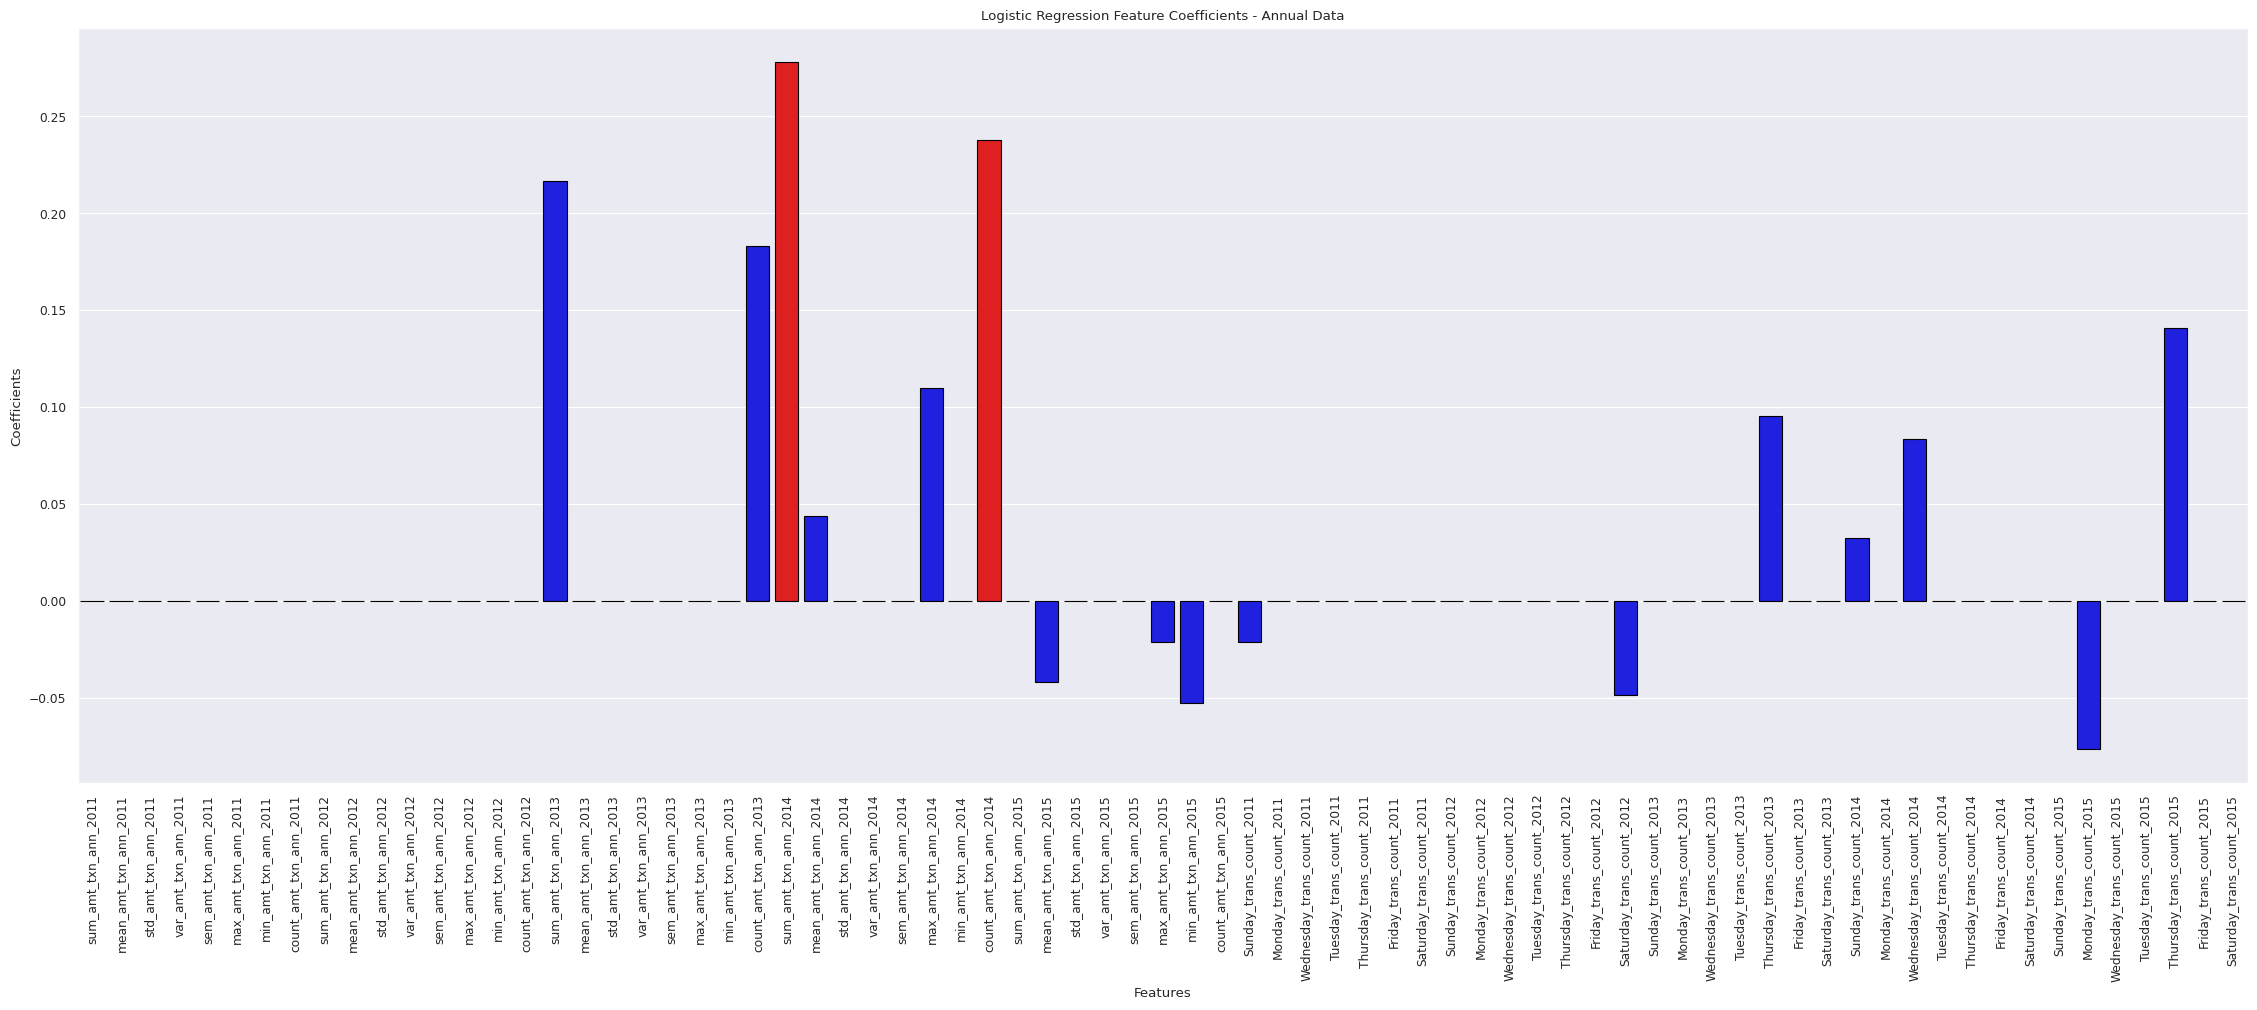

In [0]:
# Extraccting the Model coefficients and converting to Numpy()
coeff_ann_lr = best_ann_lr_model.coefficients
coeff_ann_lr = coeff_ann_lr.toArray()

# Creating a Dataframe for plotting
coeff_ann_df = pd.DataFrame({'Features': annual_cols, 'Coefficients': coeff_ann_lr})

# Plotting the Feature Coefficients
# Highlighting the highest coefficient features
colors = ['blue' if i != 24 and i != 31 else 'red' for i in range(len(annual_cols))]

plt.figure(figsize = (28,10), dpi = 100)
sns.barplot(data = coeff_ann_df, x = 'Features', y = 'Coefficients', ec = 'black', palette = colors)
plt.xticks(rotation = 90)
plt.title('Logistic Regression Feature Coefficients - Annual Data')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.show()

##### 6. Plot probability distribution for test set.

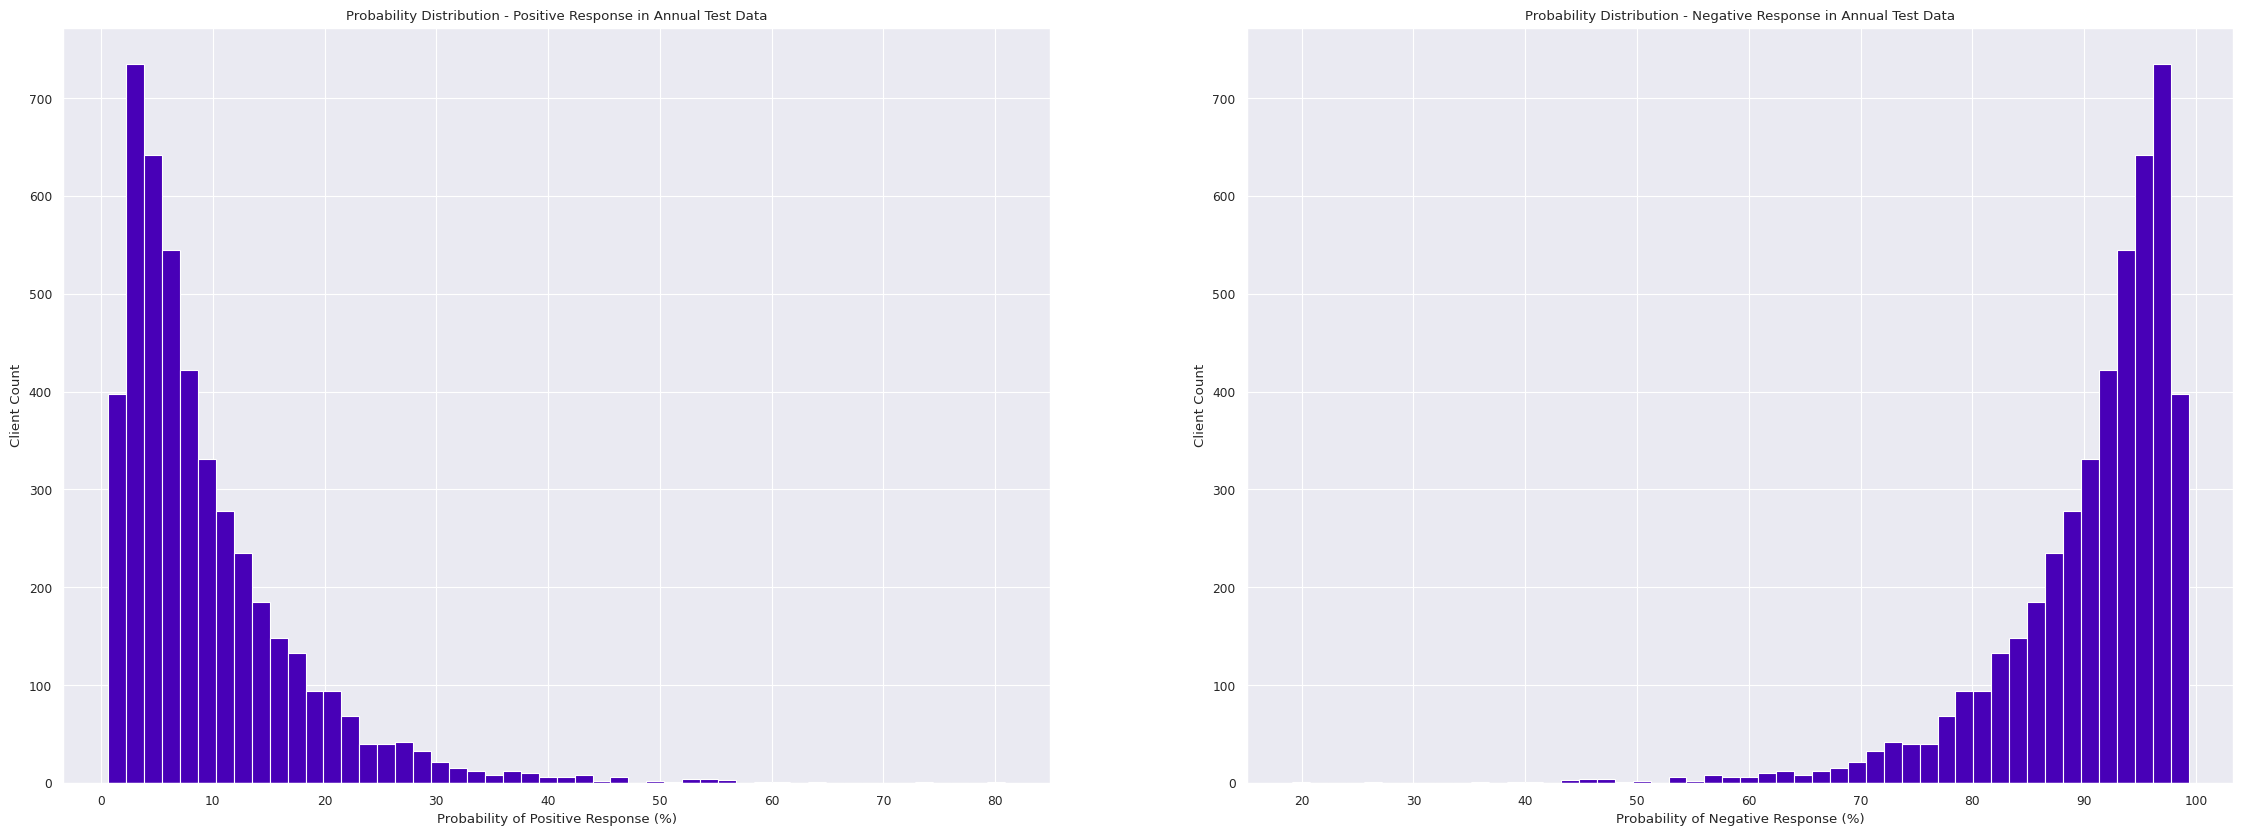

In [0]:
# Probability Distribution for Train set 
probs_train = pred_Train_annual_lr.select(col('probability')).collect()
probs_train_p = np.array([p[0][1] for p in probs_train]) # Extracting the probability for Positive responses
probs_train_p = probs_train_p * 100 
probs_train_n = np.array([p[0][0] for p in probs_train]) # Extracting the probability for Negative responses
probs_train_n = probs_train_n * 100

# Probability Distribution for Test set 
probs_test = pred_Test_annual_lr.select(col('probability')).collect()
probs_test_p = np.array([p[0][1] for p in probs_test]) # Extracting the probability for Positive responses
probs_test_p = probs_test_p * 100
probs_test_n = np.array([p[0][0] for p in probs_test]) # Extracting the probability for Negative responses
probs_test_n = probs_test_n * 100

# Plot the probability distribution
fig, ax = plt.subplots(ncols = 2,figsize = (28,10), dpi = 100)
ax[0].hist(probs_test_p, bins = 50, density = False)
ax[0].set_title('Probability Distribution - Positive Response in Annual Test Data')
ax[0].set_xlabel('Probability of Positive Response (%)')
ax[0].set_ylabel('Client Count')
ax[1].hist(probs_test_n, bins = 50, density = False)
ax[1].set_title('Probability Distribution - Negative Response in Annual Test Data')
ax[1].set_xlabel('Probability of Negative Response (%)')
ax[1].set_ylabel('Client Count')
plt.show()

##### 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

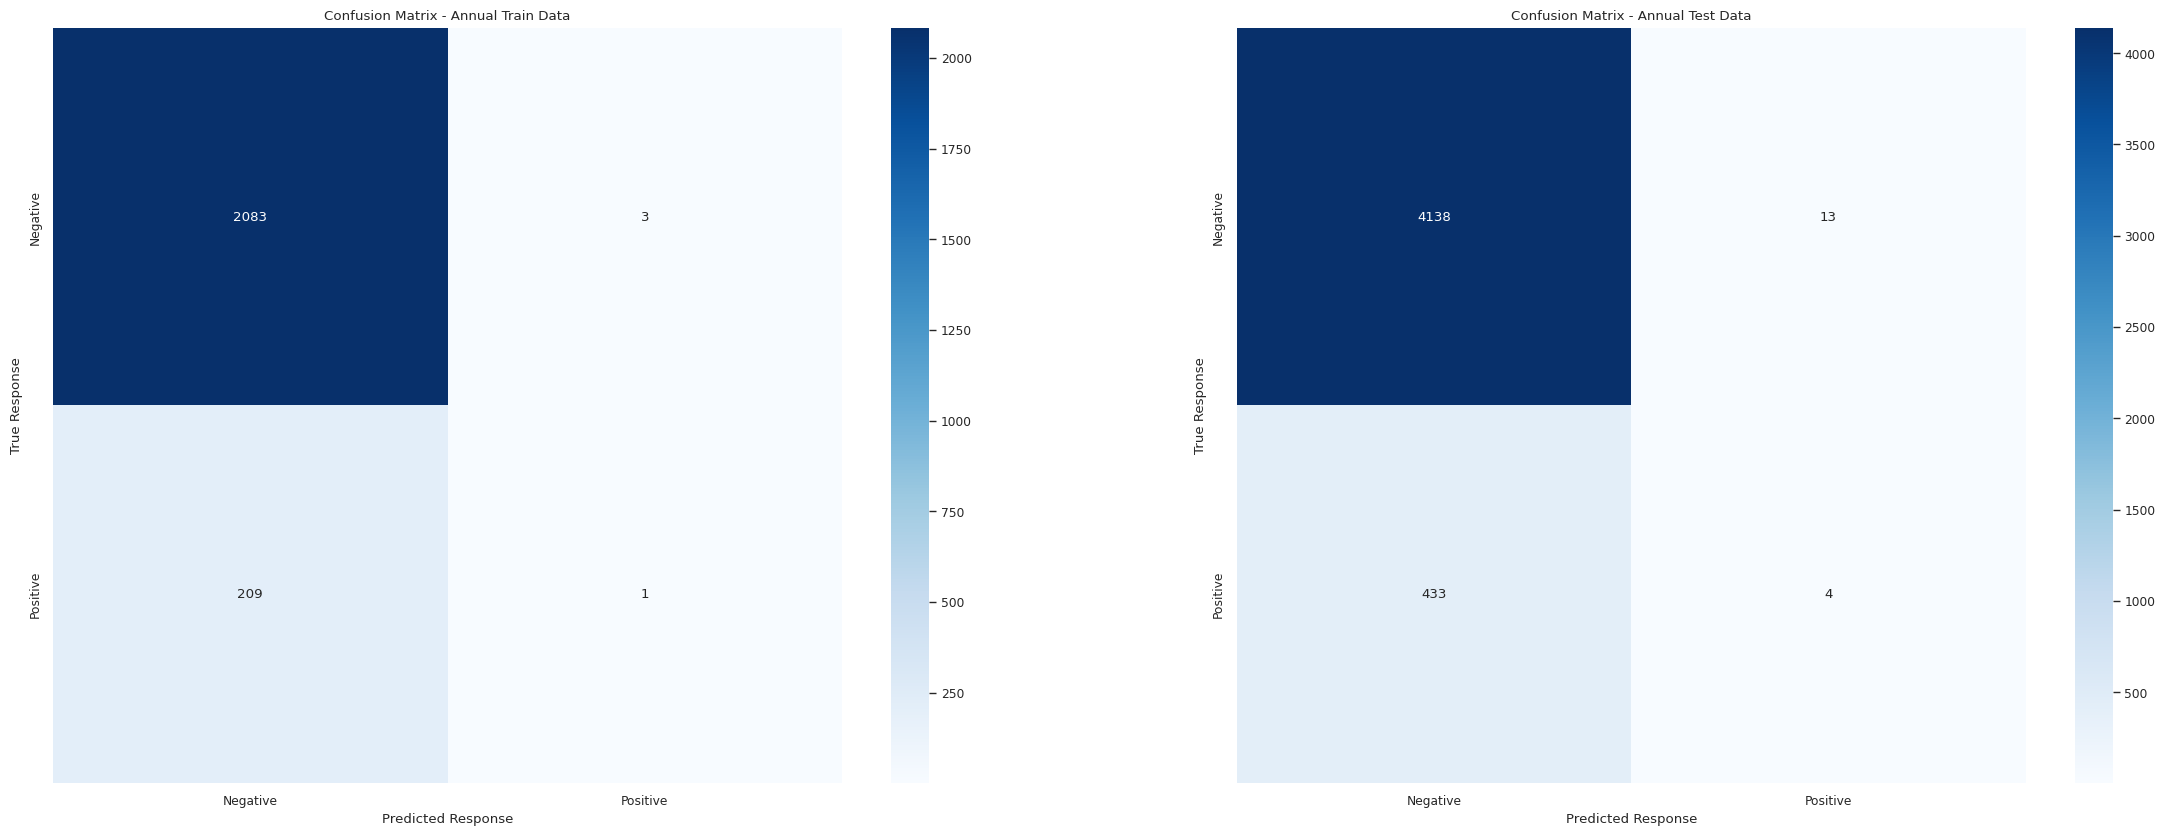

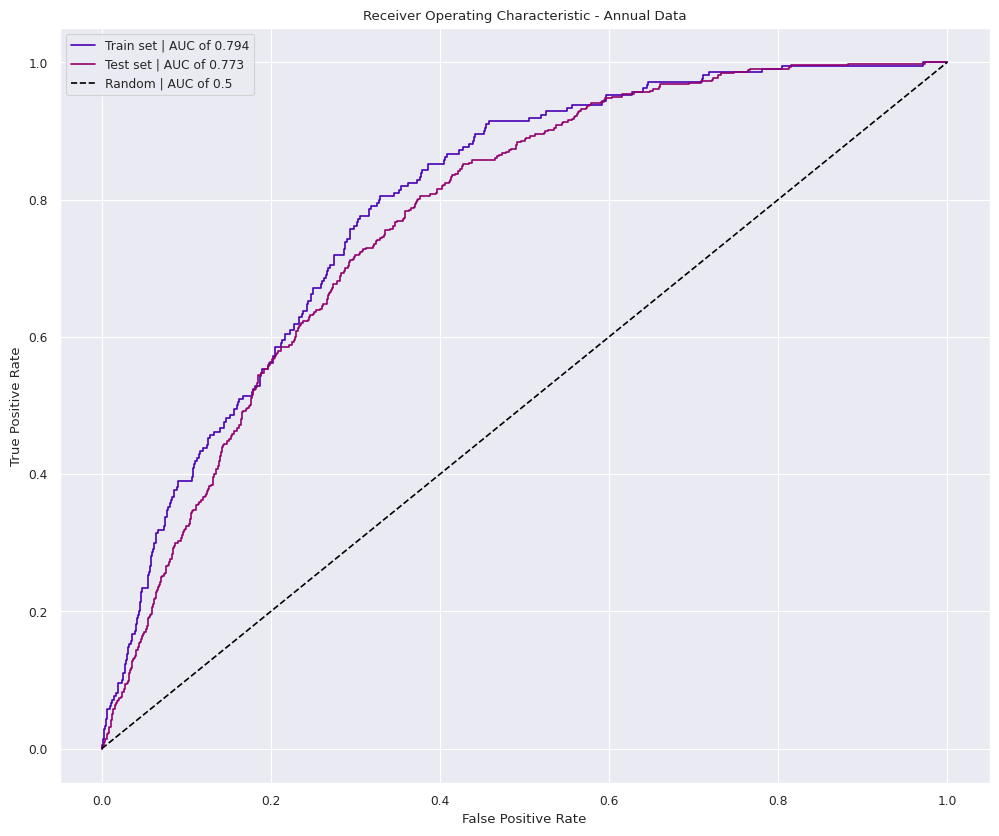

Annual Train Data Precision = 0.849
Annual Train Data Recall = 0.908
Annual Test Data Precision = 0.841
Annual Test Data Recall = 0.841


In [0]:
# Confusion Matrix Plot
y_true_train = pred_Train_annual_lr.select('response').collect()
y_pred_train = pred_Train_annual_lr.select('prediction').collect()
y_true_test = pred_Test_annual_lr.select('response').collect()
y_pred_test = pred_Test_annual_lr.select('prediction').collect()

fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (28,10), dpi = 100)
#                     Train Set
sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot = True, fmt = 'g', cmap = 'Blues', ax = ax[0])
ax[0].set_title('Confusion Matrix - Annual Train Data') 
ax[0].set_xlabel('Predicted Response')
ax[0].set_ylabel('True Response')
ax[0].xaxis.set_ticklabels(['Negative','Positive'])
ax[0].yaxis.set_ticklabels(['Negative','Positive'])

#                     Test Set
sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot = True, fmt = 'g', cmap = 'Blues', ax = ax[1])
ax[1].set_title('Confusion Matrix - Annual Test Data') 
ax[1].set_xlabel('Predicted Response')
ax[1].set_ylabel('True Response')
ax[1].xaxis.set_ticklabels(['Negative','Positive'])
ax[1].yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

# ROC Curve
#                     Train Set
pred_train = pred_Train_annual_lr.select(vector_to_array('probability')[1]).rdd.keys().collect()
true_train = pred_Train_annual_lr.select('response').rdd.keys().collect()
fpr_train, tpr_train, thresholds = roc_curve(true_train, pred_train)
auc_train_lr  = auc(fpr_train, tpr_train)

#                     Test Set
pred_test = pred_Test_annual_lr.select(vector_to_array('probability')[1]).rdd.keys().collect()
true_test = pred_Test_annual_lr.select('response').rdd.keys().collect()
fpr_test, tpr_test, thresholds = roc_curve(true_test, pred_test)
auc_test_lr  = auc(fpr_test, tpr_test)

#        ROC Plot with Train and Test Sets
plt.figure(figsize = (12,10), dpi = 100)
plt.title('Receiver Operating Characteristic - Annual Data')
plt.plot(fpr_train, tpr_train, label = 'Train set | AUC of {:4.3f}'.format(auc_train_lr));
plt.plot(fpr_test, tpr_test, label = 'Test set | AUC of {:4.3f}'.format(auc_test_lr));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

# Calculate Precision and Recall 
#                     Train Set
precision_train = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedPrecision').evaluate(pred_Train_annual_lr)
recall_train = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedRecall').evaluate(pred_Train_annual_lr)
print('Annual Train Data Precision = {:.3f}'.format(precision_train))
print('Annual Train Data Recall = {:.3f}'.format(recall_train))
# print(classification_report(y_true_train, y_pred_train))

#                     Test Set
precision_test = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedPrecision').evaluate(pred_Test_annual_lr)
recall_test = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedRecall').evaluate(pred_Test_annual_lr)
print('Annual Test Data Precision = {:.3f}'.format(precision_test))
print('Annual Test Data Recall = {:.3f}'.format(precision_test))
# print(classification_report(y_true_test, y_pred_test))

#### Decision Tree

##### 4. Fit the training dataset and optimize the hyperparameters of the method.

In [0]:
# Decision Tree model
dt = DecisionTreeClassifier(featuresCol = 'scaled_features', labelCol = 'response')

# Pipeline to chain the scaler and the model
# pipeline_dt = Pipeline(stages=[annual_Assembler, dt])

# Hyperparameter Tuning
# print(dt.explainParams())
Dt_Evaluator = MulticlassClassificationEvaluator(labelCol = 'response')
# Impurity = ['gini', 'entropy']
Max_Bins = [20, 40, 60] # [10, 20, 30] >>> Best - 10 (Overfitting)
Max_Depth = [2, 4, 6] 

# Parameter grid to search for optimal hyperparameters
param_grid_dt = ParamGridBuilder() \
                .addGrid(dt.maxBins, Max_Bins) \
                .addGrid(dt.maxDepth, Max_Depth) \
                .build()

# 5-Cross-Validator to perform Cross-Validation
dt_cv = CrossValidator(estimator = dt, estimatorParamMaps = param_grid_dt, evaluator = Dt_Evaluator, numFolds = 5, seed = 1147)

# Fit the scaled train data to the cross-validator to obtain the best model
ann_dt_model = dt_cv.fit(scaled_Train_annual)

# Transform the train and test set
pred_Train_annual_dt = ann_dt_model.transform(scaled_Train_annual)
pred_Test_annual_dt = ann_dt_model.transform(scaled_Test_annual)

# Obtain the optimal hyperparameters of the best model
best_ann_dt_model = ann_dt_model.bestModel
# best_imputrity = best_ann_dt_model.getImpurity()
best_max_bins = best_ann_dt_model.getMaxBins()
best_max_depth = best_ann_dt_model.getMaxDepth()

# print('The best Impurity is: ', best_imputrity)
print('The best Max Bin is: ', best_max_bins)
print('The best Max Depth is: ', best_max_depth)

The best Max Bin is:  20
The best Max Depth is:  4


##### 5. Plot coefficient values or feature importance.

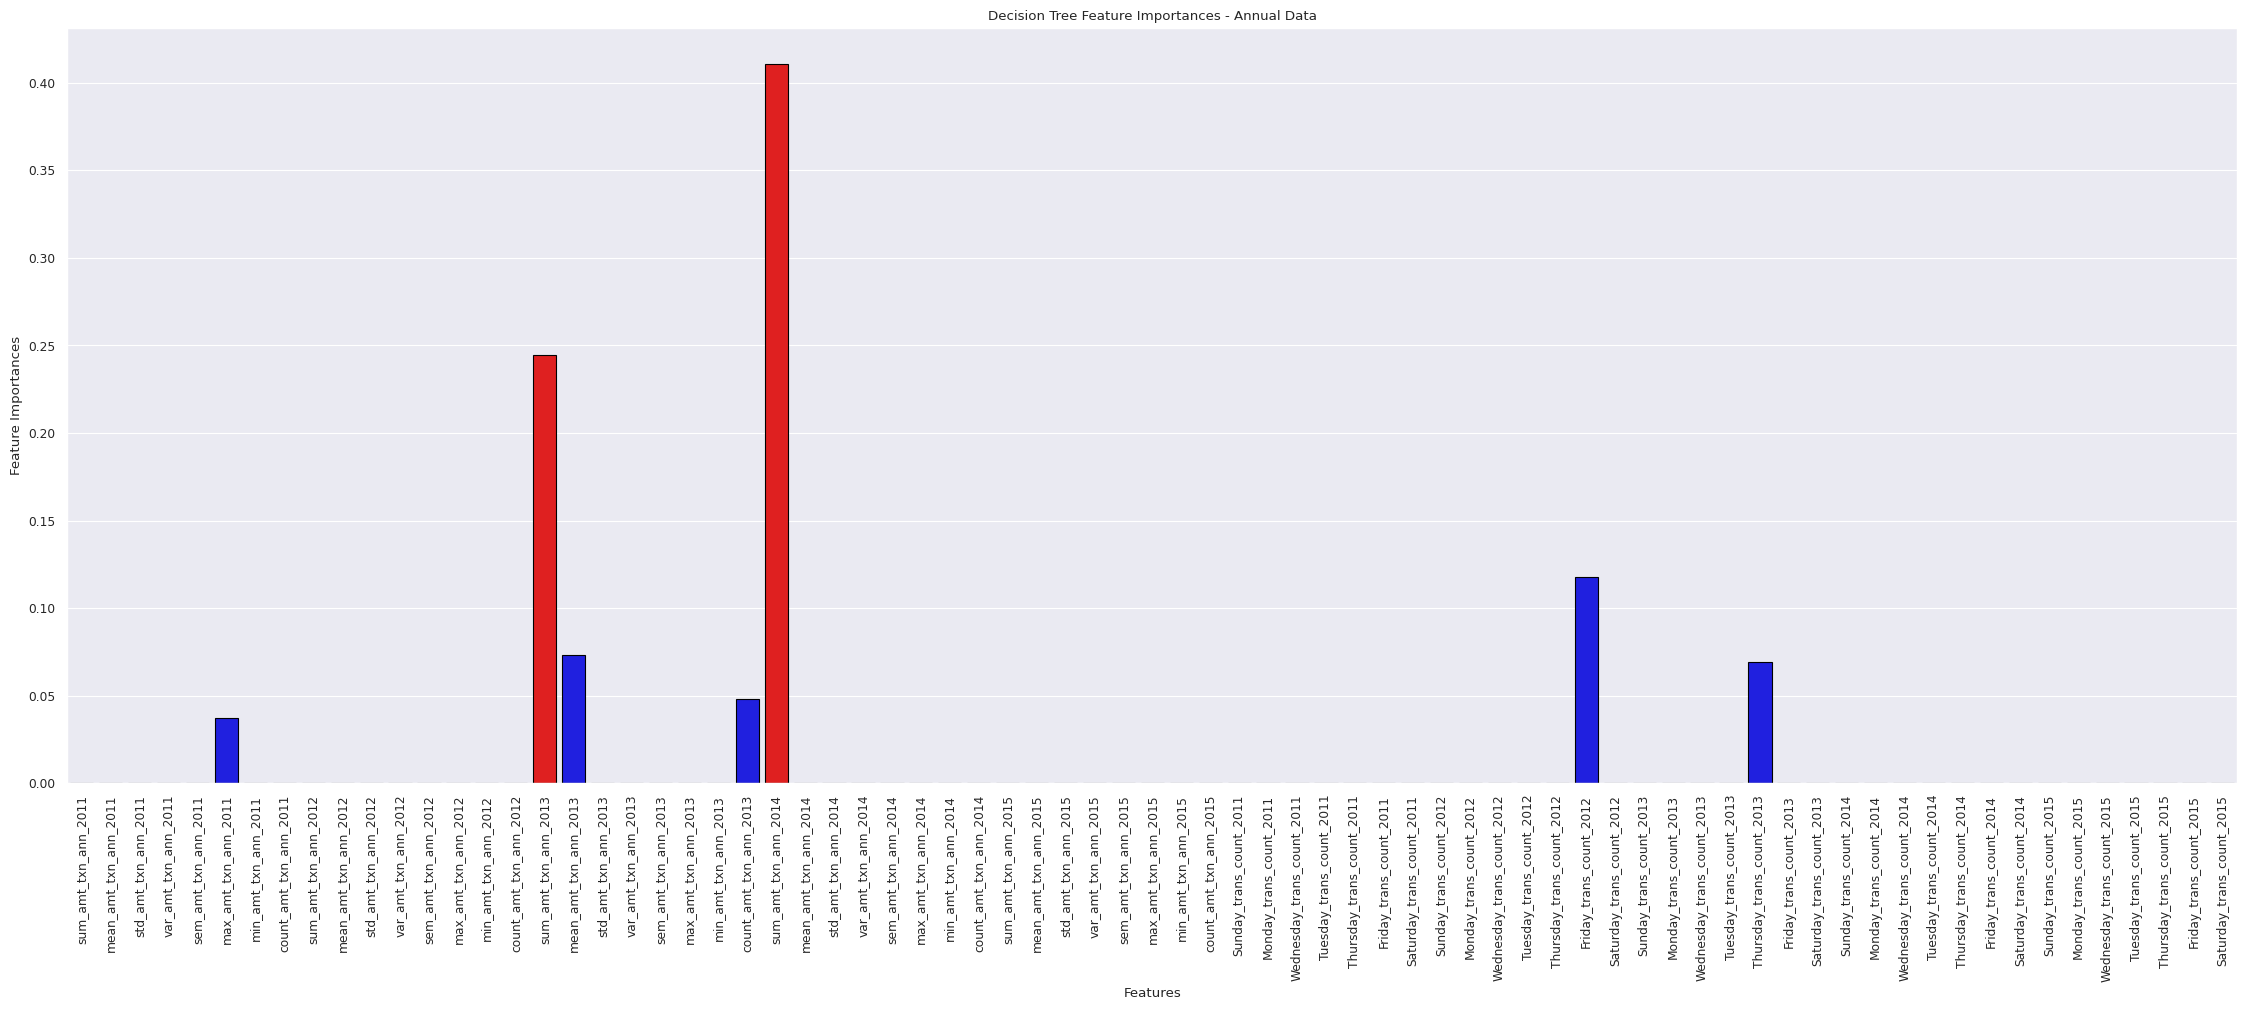

In [0]:
# Extraccting the Model coefficients and converting to Numpy()
feature_imp_ann_dt = best_ann_dt_model.featureImportances
feature_imp_ann_dt = feature_imp_ann_dt.toArray()

# Creating a Dataframe for plotting
feature_imp_ann_dt = pd.DataFrame({'Features': annual_cols, 'Feature Importances': feature_imp_ann_dt})

# Plotting the Feature Coefficients
# Highlighting the highest coefficient features
colors = ['blue' if i != 16 and i != 24 else 'red' for i in range(len(annual_cols))]

plt.figure(figsize = (28,10), dpi = 100)
sns.barplot(data = feature_imp_ann_dt, x = 'Features', y = 'Feature Importances', ec = 'black', palette = colors)
plt.xticks(rotation = 90)
plt.title('Decision Tree Feature Importances - Annual Data')
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.show()

##### 6. Plot probability distribution for test set.

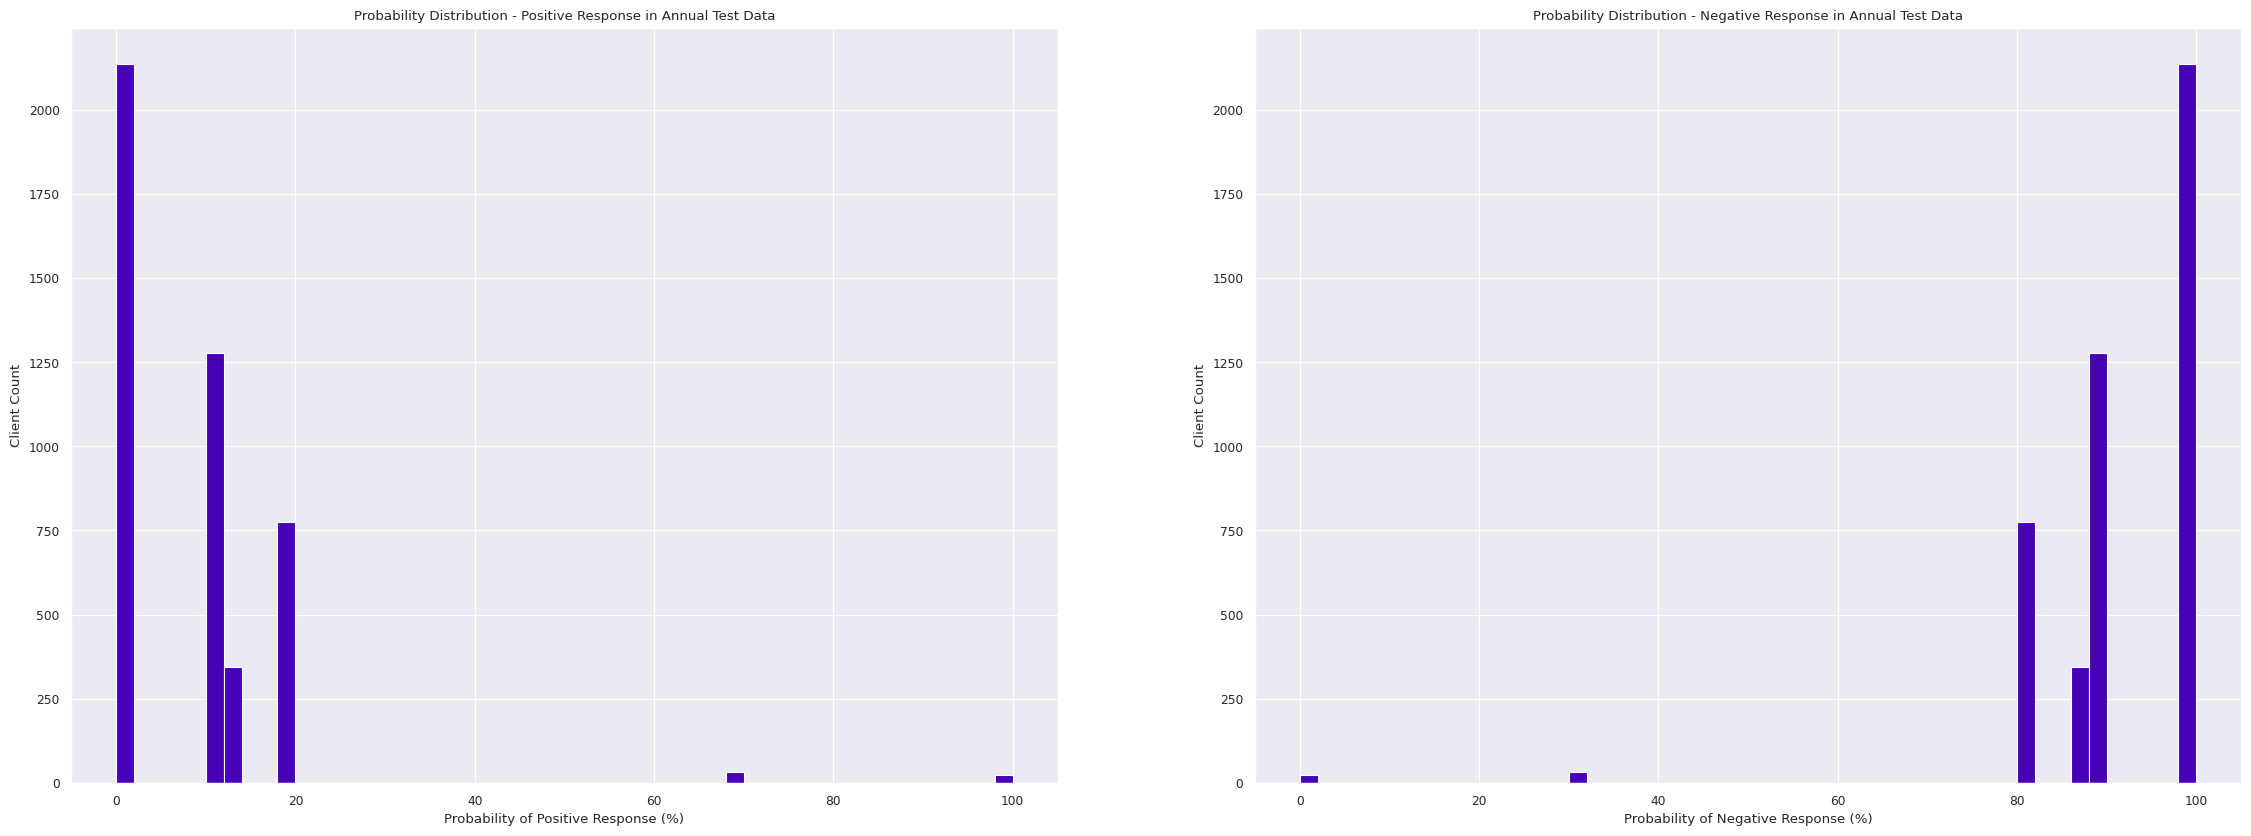

In [0]:
# Probability Distribution for Train set 
probs_train = pred_Train_annual_dt.select(col('probability')).collect()
probs_train_p = np.array([p[0][1] for p in probs_train]) # Extracting the probability for Positive responses
probs_train_p = probs_train_p * 100 
probs_train_n = np.array([p[0][0] for p in probs_train]) # Extracting the probability for Negative responses
probs_train_n = probs_train_n * 100

# Probability Distribution for Test set 
probs_test = pred_Test_annual_dt.select(col('probability')).collect()
probs_test_p = np.array([p[0][1] for p in probs_test]) # Extracting the probability for Positive responses
probs_test_p = probs_test_p * 100
probs_test_n = np.array([p[0][0] for p in probs_test]) # Extracting the probability for Negative responses
probs_test_n = probs_test_n * 100

# Plot the probability distribution
fig, ax = plt.subplots(ncols = 2,figsize = (28,10), dpi = 100)
ax[0].hist(probs_test_p, bins = 50, density = False)
ax[0].set_title('Probability Distribution - Positive Response in Annual Test Data')
ax[0].set_xlabel('Probability of Positive Response (%)')
ax[0].set_ylabel('Client Count')
ax[1].hist(probs_test_n, bins = 50, density = False)
ax[1].set_title('Probability Distribution - Negative Response in Annual Test Data')
ax[1].set_xlabel('Probability of Negative Response (%)')
ax[1].set_ylabel('Client Count')
plt.show()

##### 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

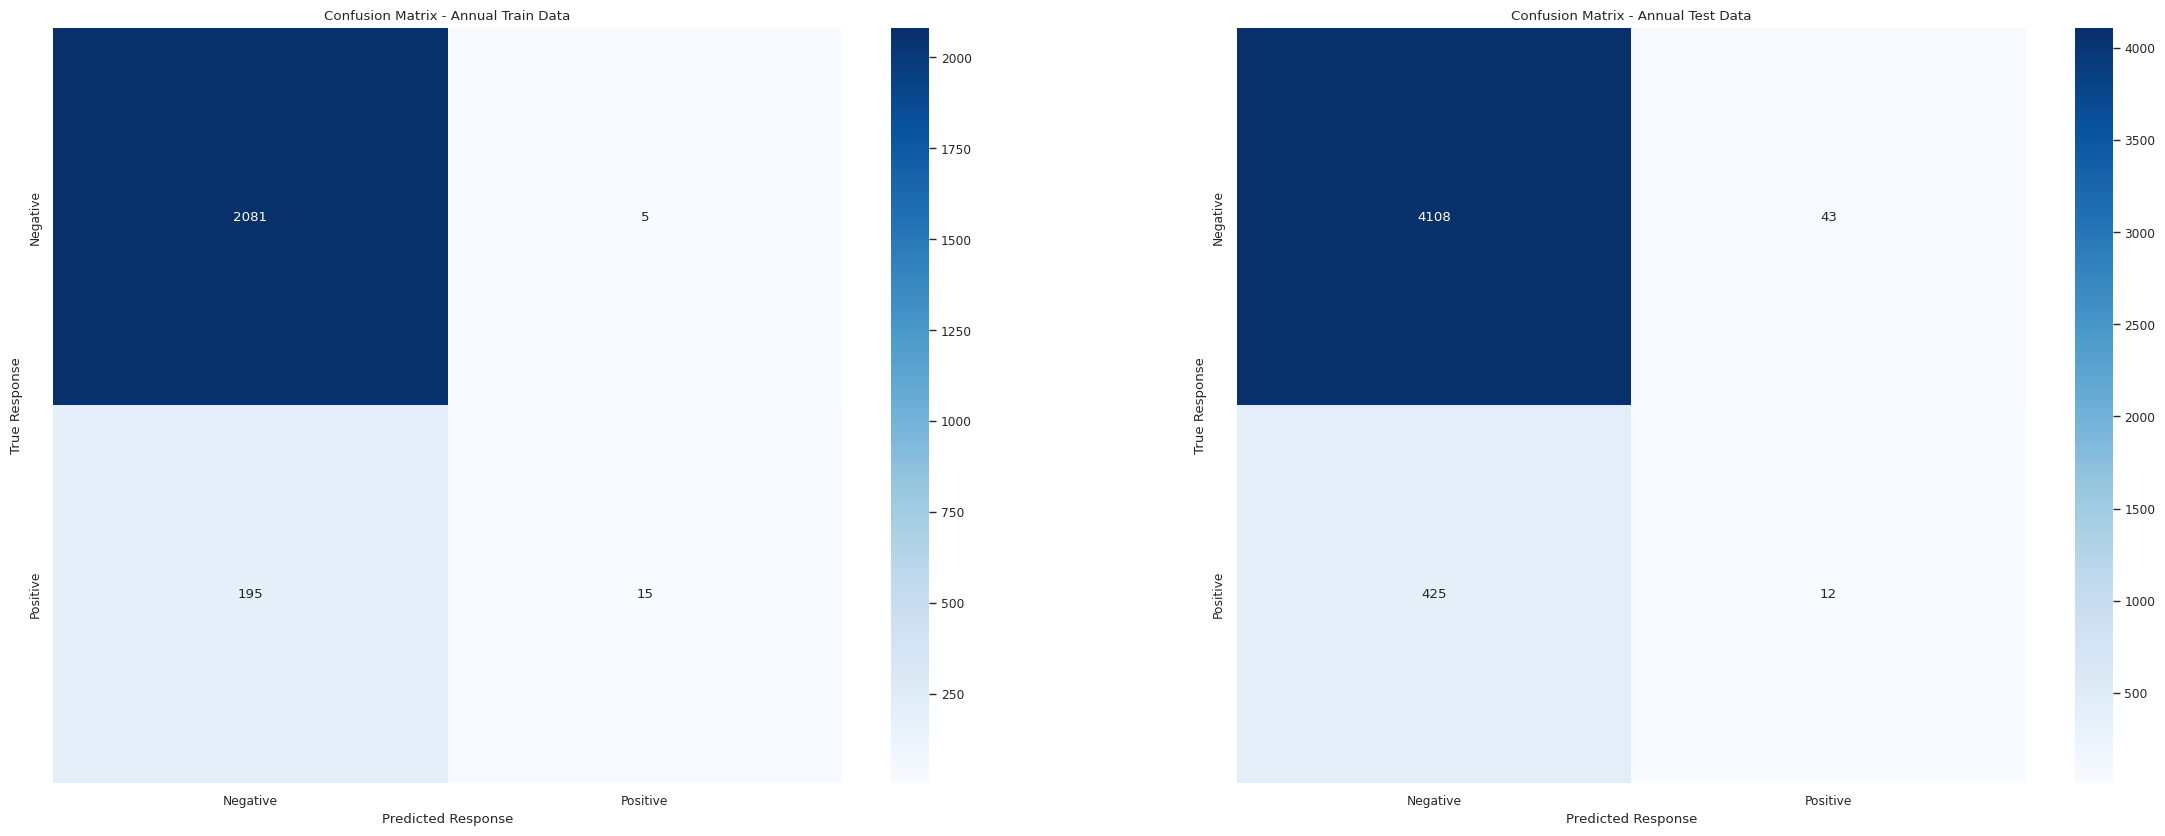

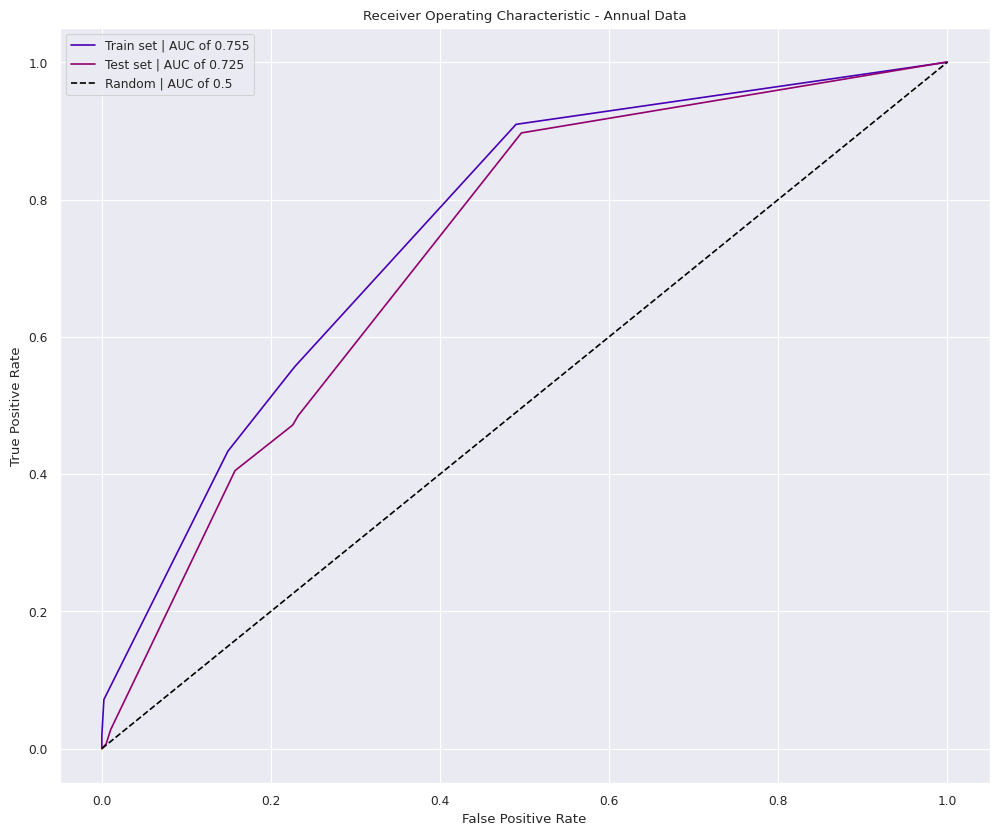

Annual Train Data Precision = 0.899
Annual Train Data Recall = 0.913
Annual Test Data Precision = 0.841
Annual Test Data Recall = 0.841


In [0]:
# Confusion Matrix Plot
y_true_train = pred_Train_annual_dt.select('response').collect()
y_pred_train = pred_Train_annual_dt.select('prediction').collect()
y_true_test = pred_Test_annual_dt.select('response').collect()
y_pred_test = pred_Test_annual_dt.select('prediction').collect()

fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (28,10), dpi = 100)
#                     Train Set
sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot = True, fmt = 'g', cmap = 'Blues', ax = ax[0])
ax[0].set_title('Confusion Matrix - Annual Train Data') 
ax[0].set_xlabel('Predicted Response')
ax[0].set_ylabel('True Response')
ax[0].xaxis.set_ticklabels(['Negative','Positive'])
ax[0].yaxis.set_ticklabels(['Negative','Positive'])

#                     Test Set
sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot = True, fmt = 'g', cmap = 'Blues', ax = ax[1])
ax[1].set_title('Confusion Matrix - Annual Test Data') 
ax[1].set_xlabel('Predicted Response')
ax[1].set_ylabel('True Response')
ax[1].xaxis.set_ticklabels(['Negative','Positive'])
ax[1].yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

# ROC Curve
#                     Train Set
pred_train = pred_Train_annual_dt.select(vector_to_array('probability')[1]).rdd.keys().collect()
true_train = pred_Train_annual_dt.select('response').rdd.keys().collect()
fpr_train, tpr_train, thresholds = roc_curve(true_train, pred_train)
auc_train_dt  = auc(fpr_train, tpr_train)

#                     Test Set
pred_test = pred_Test_annual_dt.select(vector_to_array('probability')[1]).rdd.keys().collect()
true_test = pred_Test_annual_dt.select('response').rdd.keys().collect()
fpr_test, tpr_test, thresholds = roc_curve(true_test, pred_test)
auc_test_dt  = auc(fpr_test, tpr_test)

#        ROC Plot with Train and Test Sets
plt.figure(figsize = (12,10), dpi = 100)
plt.title('Receiver Operating Characteristic - Annual Data')
plt.plot(fpr_train, tpr_train, label = 'Train set | AUC of {:4.3f}'.format(auc_train_dt));
plt.plot(fpr_test, tpr_test, label = 'Test set | AUC of {:4.3f}'.format(auc_test_dt));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

# Calculate Precision and Recall 
#                     Train Set
precision_train = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedPrecision').evaluate(pred_Train_annual_dt)
recall_train = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedRecall').evaluate(pred_Train_annual_dt)
print('Annual Train Data Precision = {:.3f}'.format(precision_train))
print('Annual Train Data Recall = {:.3f}'.format(recall_train))
# print(classification_report(y_true, y_pred))

#                     Test Set
precision_test = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedPrecision').evaluate(pred_Test_annual_dt)
recall_test = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedRecall').evaluate(pred_Test_annual_dt)
print('Annual Test Data Precision = {:.3f}'.format(precision_test))
print('Annual Test Data Recall = {:.3f}'.format(precision_test))
# print(classification_report(y_true, y_pred))

#### Random Forest

##### 4. Fit the training dataset and optimize the hyperparameters of the method.

In [0]:
# Random Forest model
rf = RandomForestClassifier(featuresCol = 'scaled_features', labelCol = 'response')

# Pipeline to chain the scaler and the model
# pipeline_rf = Pipeline(stages=[monthly_Assembler, rf])

# Hyperparameter Tuning
# print(rf.explainParams())
Rf_Evaluator = MulticlassClassificationEvaluator(labelCol = 'response')
Num_Trees = [10, 20, 30] # [20, 40, 60] >>> Best = 40 (Underfitting) | [10, 20, 30] >>> Best = 20 (Overfitting)
Max_Depth = [6, 8, 10]  # [2, 4, 6] >>> Best = 6 (Overfitting Overall)
Subset_Strategy = ['all', 'sqrt', 'log2']
# Min_Instanes_per_node = [10, 50, 100]

# Parameter grid to search for optimal hyperparameters
param_grid_rf = ParamGridBuilder() \
                .addGrid(rf.featureSubsetStrategy, Subset_Strategy) \
                .addGrid(rf.numTrees, Num_Trees) \
                .build()
#               .addGrid(rf.maxDepth, Max_Depth) \ |Keeping it here because it gives 'Indentation Error' if I quote it in the param_gird code|

# 5-Cross-Validator to perform Cross-Validation
rf_cv = CrossValidator(estimator = rf, estimatorParamMaps = param_grid_rf, evaluator = Rf_Evaluator, numFolds = 5, seed = 1147)

# Fit the scaled train data to the cross-validator to obtain the best model
ann_rf_model = rf_cv.fit(scaled_Train_annual)

# Transform the train and test set
pred_Train_annual_rf = ann_rf_model.transform(scaled_Train_annual)
pred_Test_annual_rf = ann_rf_model.transform(scaled_Test_annual)

In [0]:
# Obtain the optimal hyperparameters of the best model
best_ann_rf_model = ann_rf_model.bestModel
best_num_tress = best_ann_rf_model._java_obj.getNumTrees()
best_max_depth = best_ann_rf_model.getMaxDepth()
best_subset_strategy = best_ann_rf_model.getFeatureSubsetStrategy()
best_min_inst = best_ann_rf_model.getMinInstancesPerNode()

# print('The best Impurity is: ', best_imputrity)
print('The best Num Tree is: ', best_num_tress)
print('The best Max Depth is: ', best_max_depth)
print('The best Feature Subset Strategy is: ', best_subset_strategy)
print('The best Min Instances / Node is: ', best_min_inst)

The best Num Tree is:  20
The best Max Depth is:  5
The best Feature Subset Strategy is:  all
The best Min Instances / Node is:  1


##### 5. Plot coefficient values or feature importance.

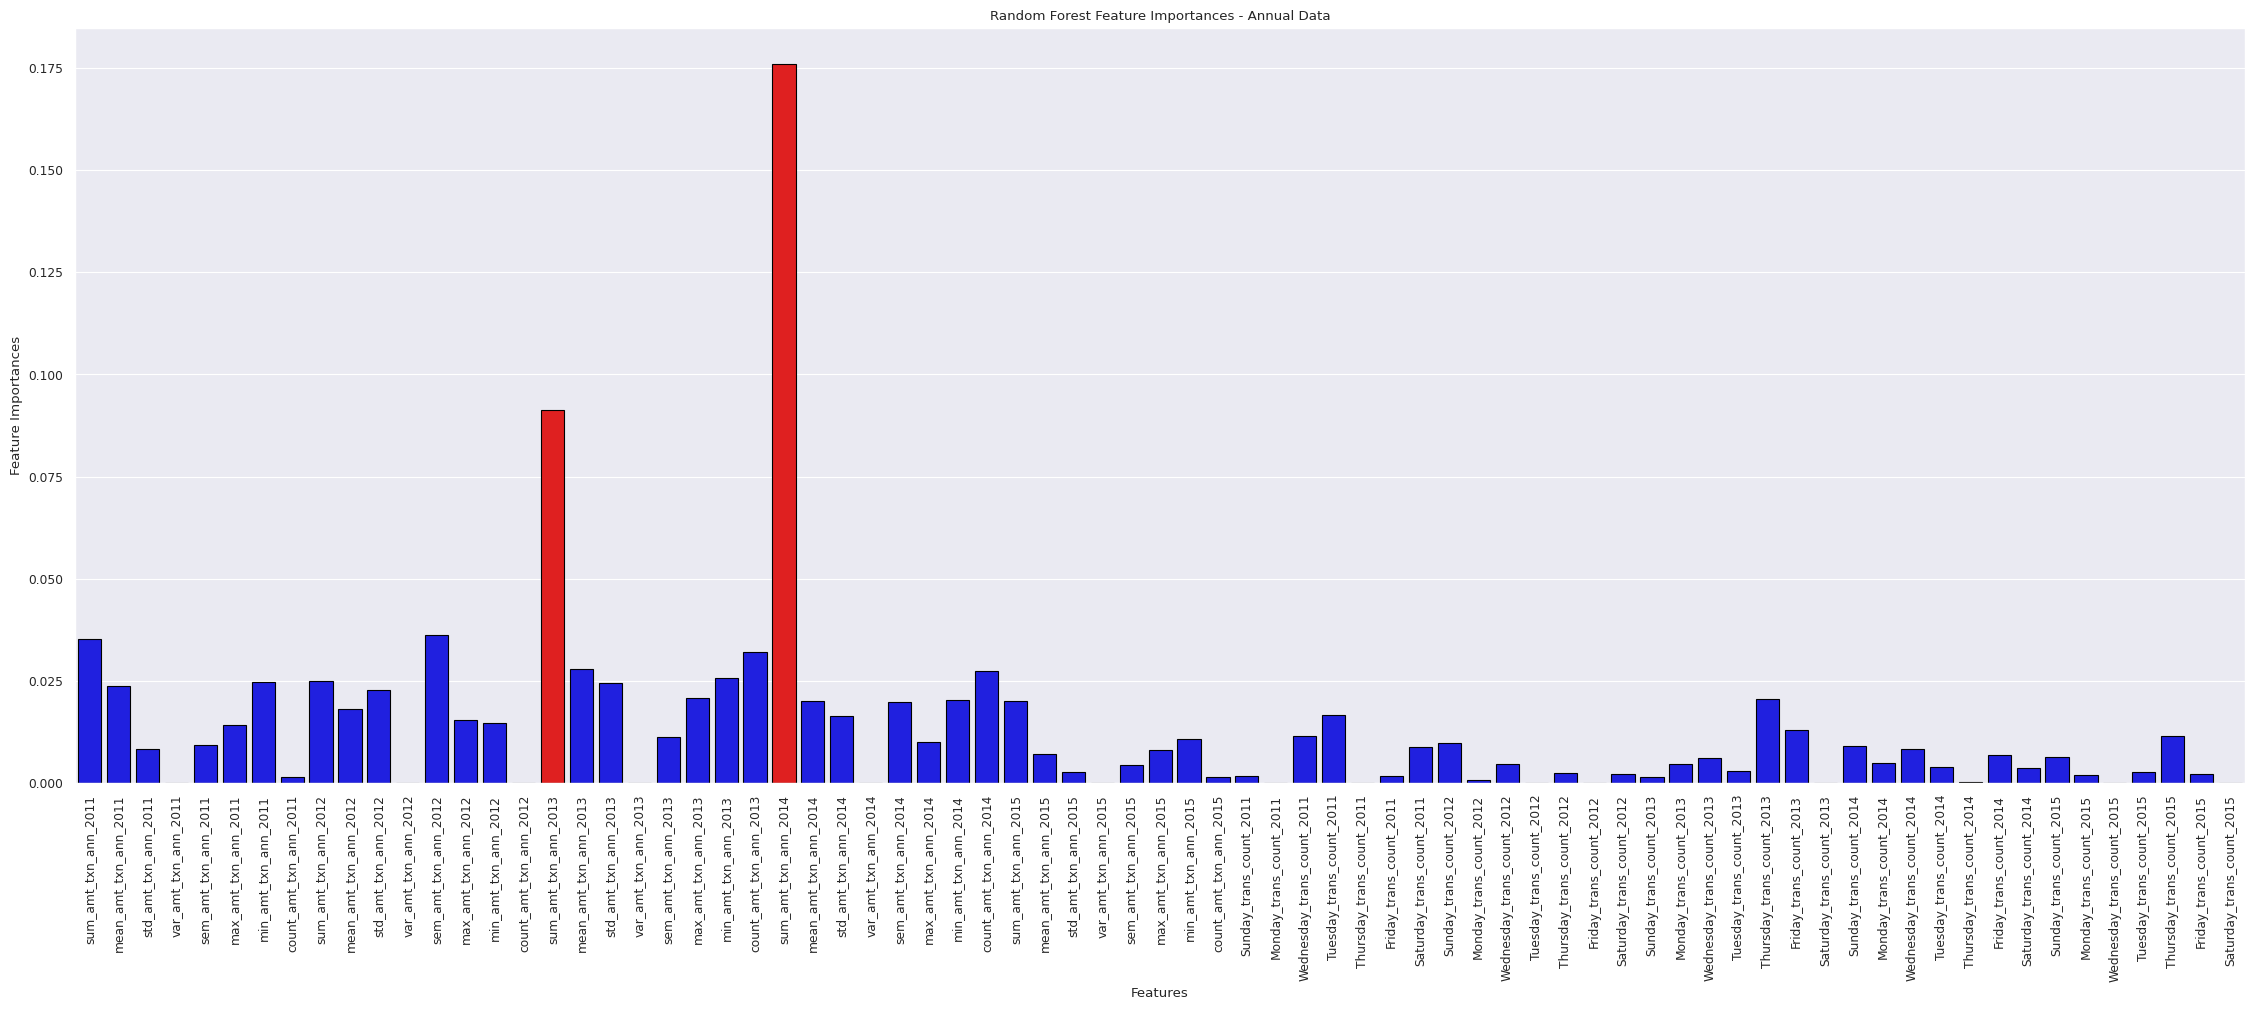

In [0]:
# Extracting the Model coefficients and converting to Numpy()
feature_imp_ann_rf = best_ann_rf_model.featureImportances
feature_imp_ann_rf = feature_imp_ann_rf.toArray()

# Creating a Dataframe for plotting
feature_imp_ann_rf = pd.DataFrame({'Features': annual_cols, 'Feature Importances': feature_imp_ann_rf})

# Plotting the Feature Coefficients
# Highlighting the highest coefficient features
colors = ['blue' if i != 16 and i != 24 else 'red' for i in range(len(annual_cols))]

plt.figure(figsize = (28,10), dpi = 100)
sns.barplot(data = feature_imp_ann_rf, x = 'Features', y = 'Feature Importances', ec = 'black', palette = colors)
plt.xticks(rotation = 90)
plt.title('Random Forest Feature Importances - Annual Data')
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.show()

##### 6. Plot probability distribution for test set.

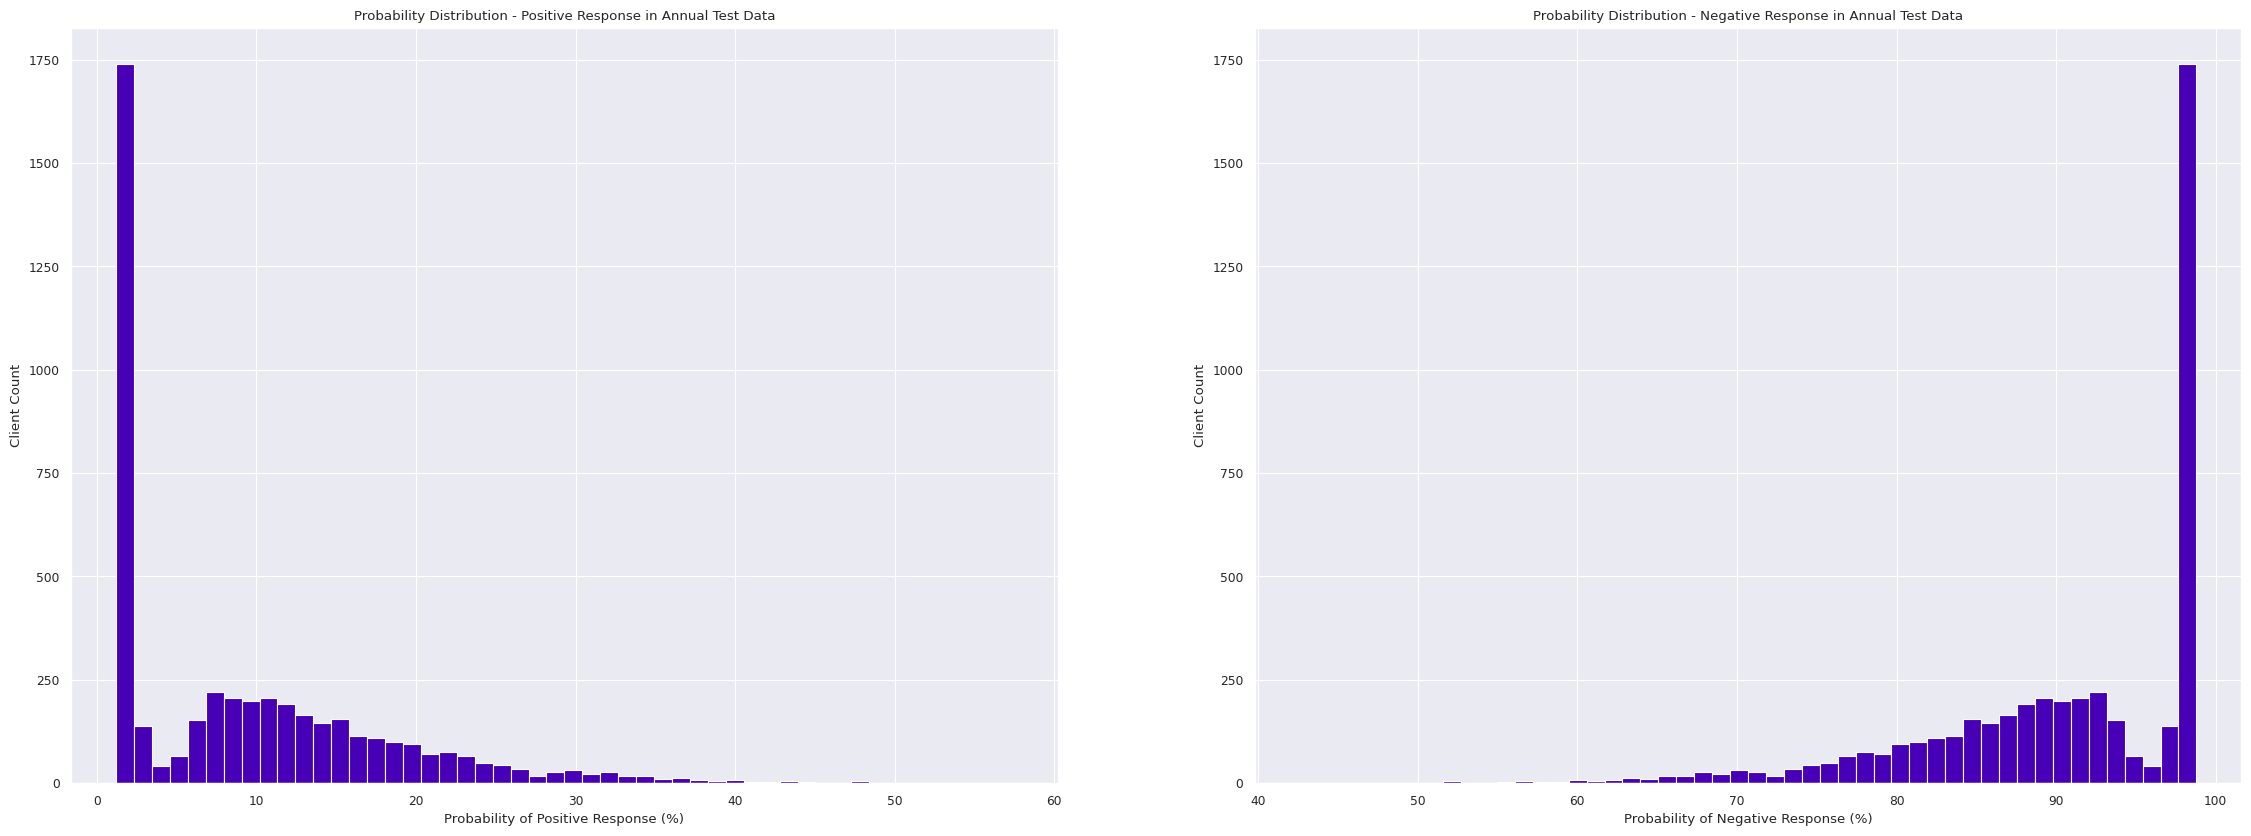

In [0]:
# Probability Distribution for Train set 
probs_train = pred_Train_annual_rf.select(col('probability')).collect()
probs_train_p = np.array([p[0][1] for p in probs_train]) # Extracting the probability for Positive responses
probs_train_p = probs_train_p * 100 
probs_train_n = np.array([p[0][0] for p in probs_train]) # Extracting the probability for Negative responses
probs_train_n = probs_train_n * 100

# Probability Distribution for Test set 
probs_test = pred_Test_annual_rf.select(col('probability')).collect()
probs_test_p = np.array([p[0][1] for p in probs_test]) # Extracting the probability for Positive responses
probs_test_p = probs_test_p * 100
probs_test_n = np.array([p[0][0] for p in probs_test]) # Extracting the probability for Negative responses
probs_test_n = probs_test_n * 100

# Plot the probability distribution
fig, ax = plt.subplots(ncols = 2,figsize = (28,10), dpi = 100)
ax[0].hist(probs_test_p, bins = 50, density = False)
ax[0].set_title('Probability Distribution - Positive Response in Annual Test Data')
ax[0].set_xlabel('Probability of Positive Response (%)')
ax[0].set_ylabel('Client Count')
ax[1].hist(probs_test_n, bins = 50, density = False)
ax[1].set_title('Probability Distribution - Negative Response in Annual Test Data')
ax[1].set_xlabel('Probability of Negative Response (%)')
ax[1].set_ylabel('Client Count')
plt.show()

##### 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

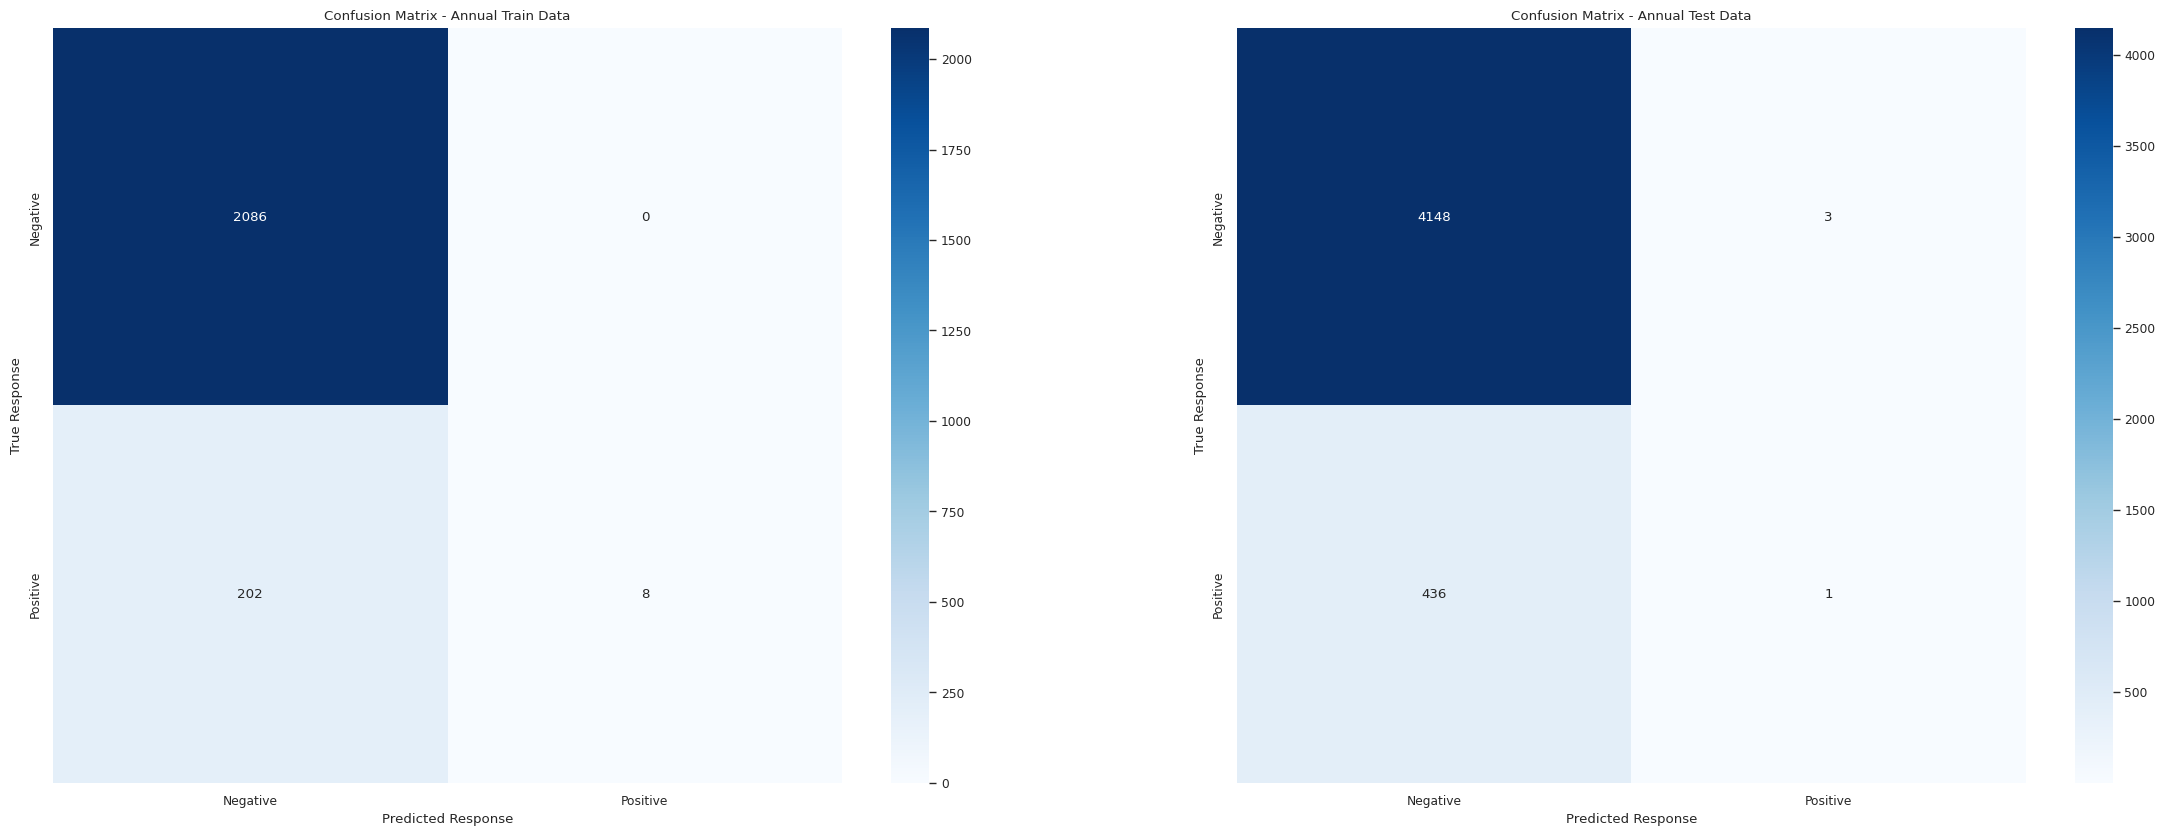

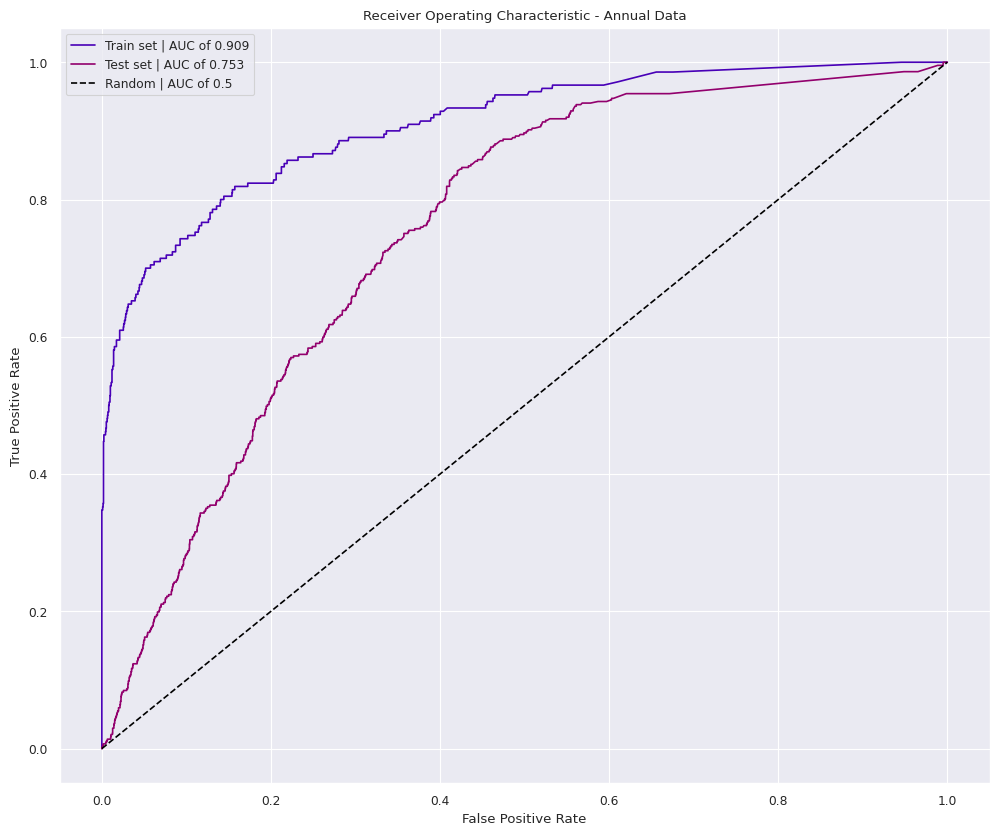

Annual Train Data Precision = 0.920
Annual Train Data Recall = 0.912
Annual Test Data Precision = 0.843
Annual Test Data Recall = 0.843


In [0]:
# Confusion Matrix Plot
y_true_train = pred_Train_annual_rf.select('response').collect()
y_pred_train = pred_Train_annual_rf.select('prediction').collect()
y_true_test = pred_Test_annual_rf.select('response').collect()
y_pred_test = pred_Test_annual_rf.select('prediction').collect()

fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (28,10), dpi = 100)
#                     Train Set
sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot = True, fmt = 'g', cmap = 'Blues', ax = ax[0])
ax[0].set_title('Confusion Matrix - Annual Train Data') 
ax[0].set_xlabel('Predicted Response')
ax[0].set_ylabel('True Response')
ax[0].xaxis.set_ticklabels(['Negative','Positive'])
ax[0].yaxis.set_ticklabels(['Negative','Positive'])

#                     Test Set
sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot = True, fmt = 'g', cmap = 'Blues', ax = ax[1])
ax[1].set_title('Confusion Matrix - Annual Test Data') 
ax[1].set_xlabel('Predicted Response')
ax[1].set_ylabel('True Response')
ax[1].xaxis.set_ticklabels(['Negative','Positive'])
ax[1].yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

# ROC Curve
#                     Train Set
pred_train = pred_Train_annual_rf.select(vector_to_array('probability')[1]).rdd.keys().collect()
true_train = pred_Train_annual_rf.select('response').rdd.keys().collect()
fpr_train, tpr_train, thresholds = roc_curve(true_train, pred_train)
auc_train_dt  = auc(fpr_train, tpr_train)

#                     Test Set
pred_test = pred_Test_annual_rf.select(vector_to_array('probability')[1]).rdd.keys().collect()
true_test = pred_Test_annual_rf.select('response').rdd.keys().collect()
fpr_test, tpr_test, thresholds = roc_curve(true_test, pred_test)
auc_test_dt  = auc(fpr_test, tpr_test)

#        ROC Plot with Train and Test Sets
plt.figure(figsize = (12,10), dpi = 100)
plt.title('Receiver Operating Characteristic - Annual Data')
plt.plot(fpr_train, tpr_train, label = 'Train set | AUC of {:4.3f}'.format(auc_train_dt));
plt.plot(fpr_test, tpr_test, label = 'Test set | AUC of {:4.3f}'.format(auc_test_dt));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

# Calculate Precision and Recall 
#                     Train Set
precision_train = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedPrecision').evaluate(pred_Train_annual_rf)
recall_train = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedRecall').evaluate(pred_Train_annual_rf)
print('Annual Train Data Precision = {:.3f}'.format(precision_train))
print('Annual Train Data Recall = {:.3f}'.format(recall_train))
# print(classification_report(y_true, y_pred))

#                     Test Set
precision_test = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedPrecision').evaluate(pred_Test_annual_rf)
recall_test = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedRecall').evaluate(pred_Test_annual_rf)
print('Annual Test Data Precision = {:.3f}'.format(precision_test))
print('Annual Test Data Recall = {:.3f}'.format(precision_test))
# print(classification_report(y_true, y_pred))

### Monthly Data

##### 4. Fit the training dataset and optimize the hyperparameters of the method.

In [0]:
# L1 Logistic Regression model
lr = LogisticRegression(featuresCol = 'scaled_features', labelCol = 'response', elasticNetParam = 1.0, family = 'Binomial')

# Pipeline to chain the scaler and the model
# pipeline_lr = Pipeline(stages=[monthly_Assembler, lr])

# Hyperparameter Tuning
# print(lr.explainParams())
Lr_Evaluator = BinaryClassificationEvaluator(labelCol = 'response')
Reg_Param = [0.0001, 0.001, 0.01]
Max_Iter = [1, 5, 10] 

# Parameter grid to search for optimal hyperparameters
param_grid_lr = ParamGridBuilder() \
                .addGrid(lr.regParam, Reg_Param) \
                .addGrid(lr.maxIter, Max_Iter) \
                .build()

# 5-Cross-Validator to perform Cross-Validation
lr_cv = CrossValidator(estimator = lr, estimatorParamMaps = param_grid_lr, evaluator = Lr_Evaluator, numFolds = 5, seed = 1147)

# Fit the scaled train data to the cross-validator to obtain the best model
mth_lr_model = lr_cv.fit(scaled_Train_monthly)

# Transform the train and test set
pred_Train_monthly_lr = mth_lr_model.transform(scaled_Train_monthly)
pred_Test_monthly_lr = mth_lr_model.transform(scaled_Test_monthly)

# Obtain the optimal hyperparameters of the best model
best_mth_lr_model = mth_lr_model.bestModel
best_reg_param = best_mth_lr_model.getRegParam()
best_max_iter = best_mth_lr_model.getMaxIter()

print('The best Regularization Parameter is: ', best_reg_param)
print('The best Max Iterations is: ', best_max_iter)

The best Regularization Parameter is:  0.0001
The best Max Iterations is:  10


##### 5. Plot coefficient values or feature importance.

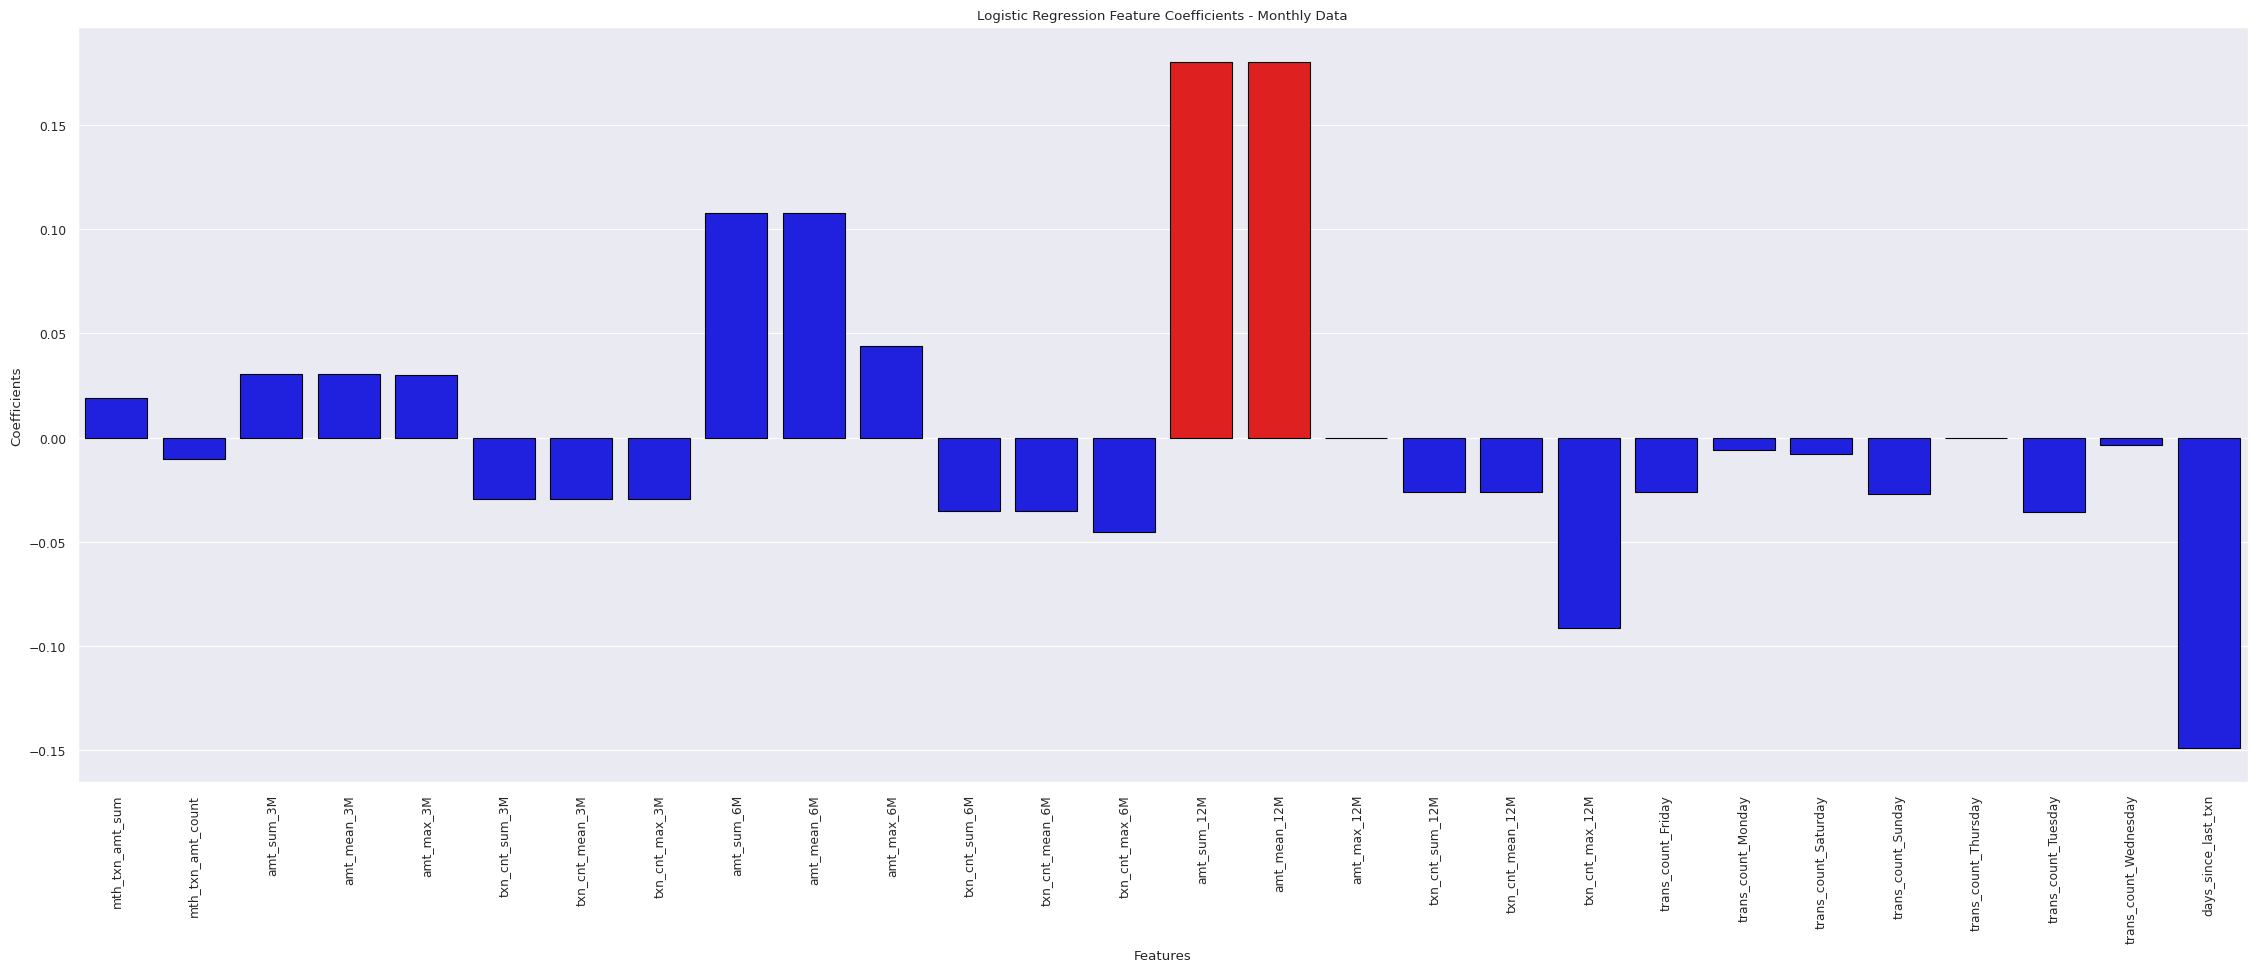

In [0]:
# Extraccting the Model coefficients and converting to Numpy()
coeff_mth_lr = best_mth_lr_model.coefficients
coeff_mth_lr = coeff_mth_lr.toArray()

# Creating a Dataframe for plotting
coeff_mth_df = pd.DataFrame({'Features': monthly_cols, 'Coefficients': coeff_mth_lr})

# Plotting the Feature Coefficients
# Highlighting the highest coefficient features
colors = ['blue' if i != 14 and i != 15 else 'red' for i in range(len(monthly_cols))]

plt.figure(figsize = (28,10), dpi = 100)
sns.barplot(data = coeff_mth_df, x = 'Features', y = 'Coefficients', ec = 'black', palette = colors)
plt.xticks(rotation = 90)
plt.title('Logistic Regression Feature Coefficients - Monthly Data')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.show()

##### 6. Plot probability distribution for test set.

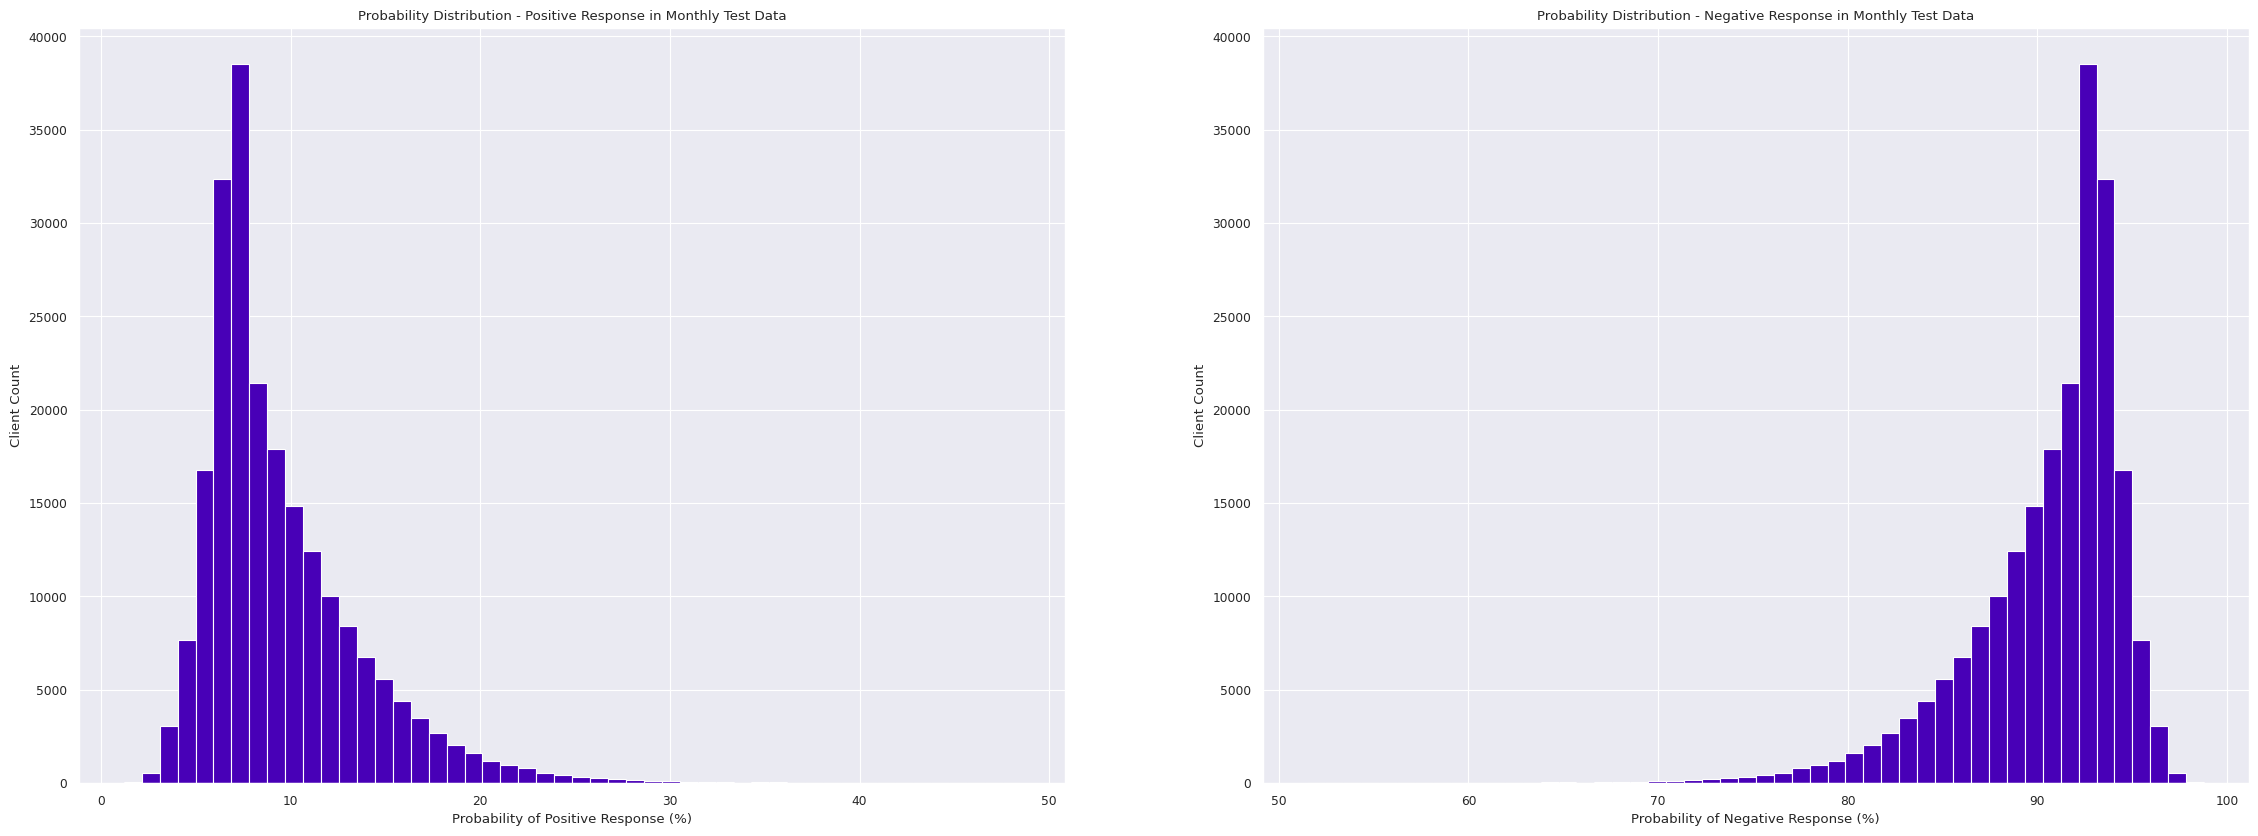

In [0]:
# Probability Distribution for Train set 
probs_train = pred_Train_monthly_lr.select(col('probability'))
probs_train_p = np.array([p[0][1] for p in probs_train]) # Extracting the probability for Positive responses
probs_train_p = probs_train_p * 100 
probs_train_n = np.array([p[0][0] for p in probs_train]) # Extracting the probability for Negative responses
probs_train_n = probs_train_n * 100
# display(probs_train_p)
# Probability Distribution for Test set 
probs_test = pred_Test_monthly_lr.select(col('probability')).collect()
probs_test_p = np.array([p[0][1] for p in probs_test]) # Extracting the probability for Positive responses
probs_test_p = probs_test_p * 100
probs_test_n = np.array([p[0][0] for p in probs_test]) # Extracting the probability for Negative responses
probs_test_n = probs_test_n * 100

# Plot the probability distribution
fig, ax = plt.subplots(ncols = 2,figsize = (28,10), dpi = 100)
ax[0].hist(probs_test_p, bins = 50, density = False)
ax[0].set_title('Probability Distribution - Positive Response in Monthly Test Data')
ax[0].set_xlabel('Probability of Positive Response (%)')
ax[0].set_ylabel('Client Count')
ax[1].hist(probs_test_n, bins = 50, density = False)
ax[1].set_title('Probability Distribution - Negative Response in Monthly Test Data')
ax[1].set_xlabel('Probability of Negative Response (%)')
ax[1].set_ylabel('Client Count')
plt.show()

##### 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

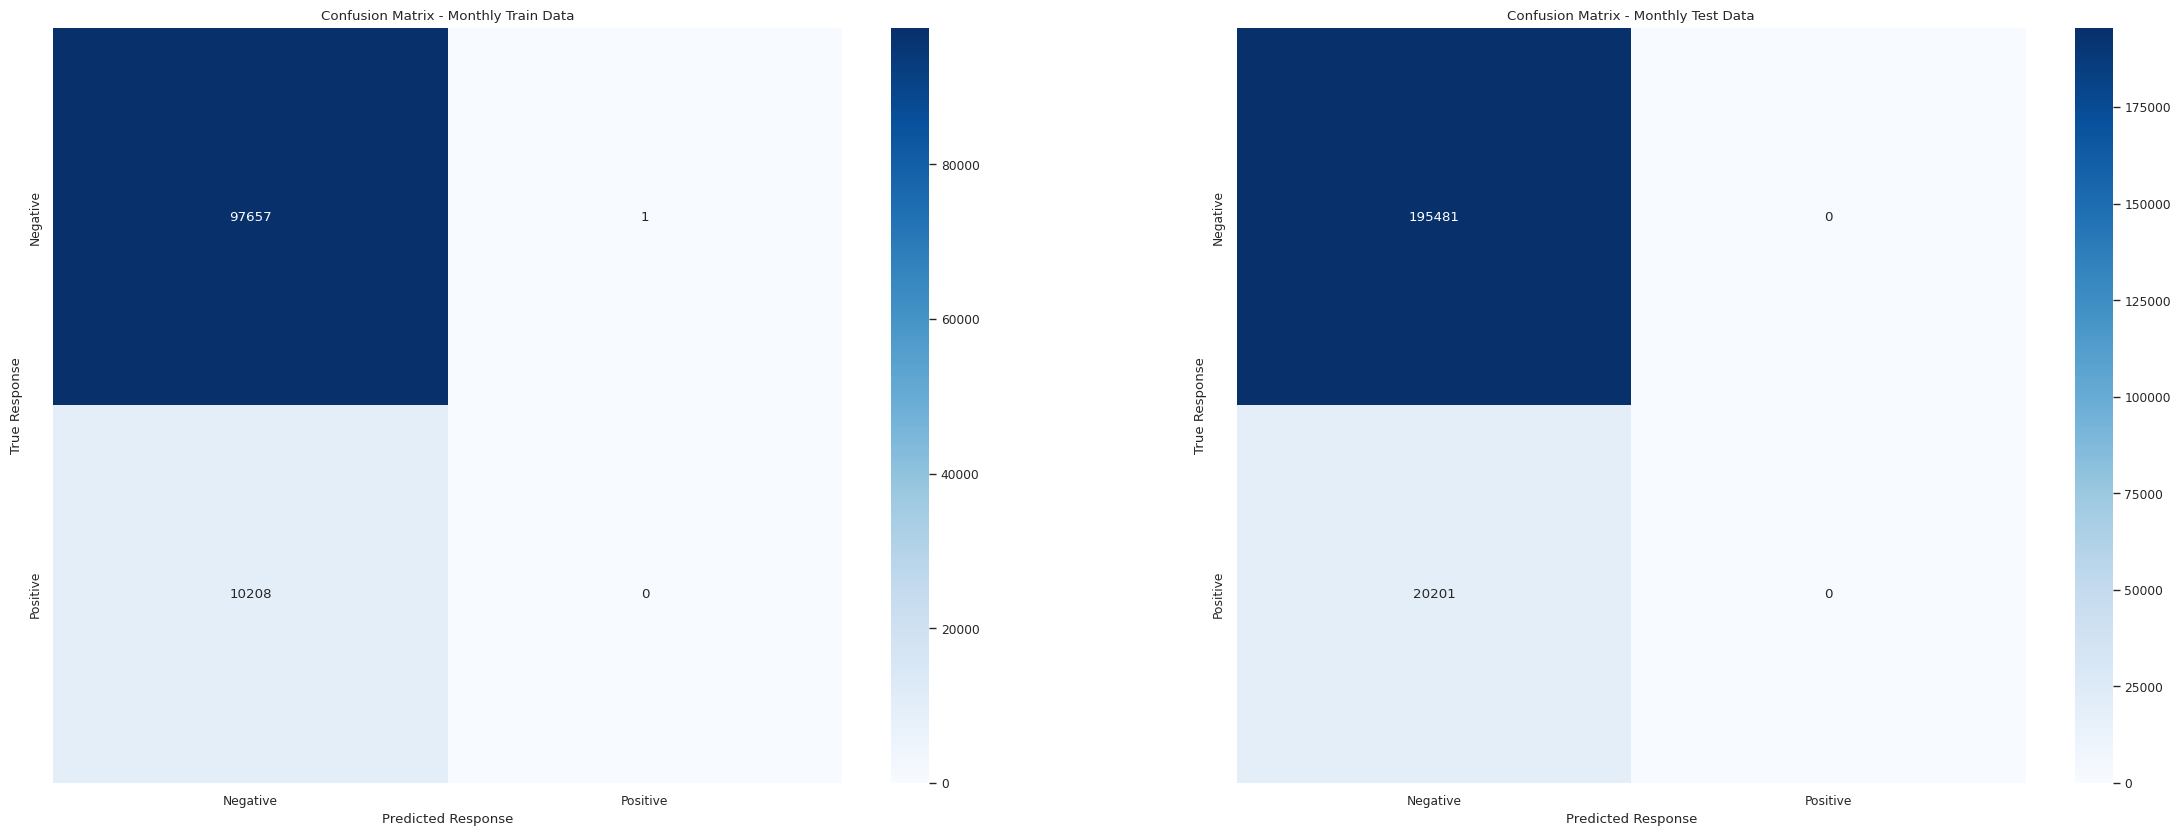

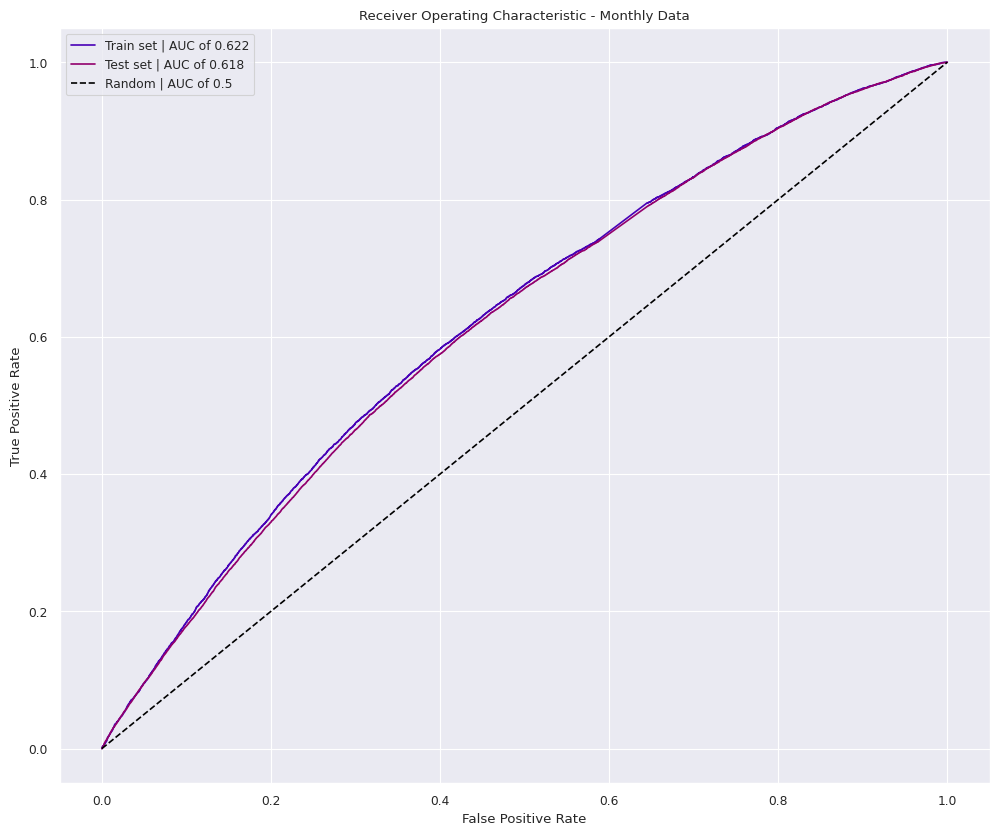

Monthly Train Data Precision = 0.820
Monthly Train Data Recall = 0.905
Monthly Test Data Precision = 0.821
Monthly Test Data Recall = 0.821


In [0]:
# Confusion Matrix Plot
y_true_train = pred_Train_monthly_lr.select('response').collect()
y_pred_train = pred_Train_monthly_lr.select('prediction').collect()
y_true_test = pred_Test_monthly_lr.select('response').collect()
y_pred_test = pred_Test_monthly_lr.select('prediction').collect()

fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (28,10), dpi = 100)
#                     Train Set
sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot = True, fmt = 'g', cmap = 'Blues', ax = ax[0])
ax[0].set_title('Confusion Matrix - Monthly Train Data') 
ax[0].set_xlabel('Predicted Response')
ax[0].set_ylabel('True Response')
ax[0].xaxis.set_ticklabels(['Negative','Positive'])
ax[0].yaxis.set_ticklabels(['Negative','Positive'])

#                     Test Set
sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot = True, fmt = 'g', cmap = 'Blues', ax = ax[1])
ax[1].set_title('Confusion Matrix - Monthly Test Data') 
ax[1].set_xlabel('Predicted Response')
ax[1].set_ylabel('True Response')
ax[1].xaxis.set_ticklabels(['Negative','Positive'])
ax[1].yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

# ROC Curve
#                     Train Set
pred_train = pred_Train_monthly_lr.select(vector_to_array('probability')[1]).rdd.keys().collect()
true_train = pred_Train_monthly_lr.select('response').rdd.keys().collect()
fpr_train, tpr_train, thresholds = roc_curve(true_train, pred_train)
auc_train_lr  = auc(fpr_train, tpr_train)

#                     Test Set
pred_test = pred_Test_monthly_lr.select(vector_to_array('probability')[1]).rdd.keys().collect()
true_test = pred_Test_monthly_lr.select('response').rdd.keys().collect()
fpr_test, tpr_test, thresholds = roc_curve(true_test, pred_test)
auc_test_lr  = auc(fpr_test, tpr_test)

#        ROC Plot with Train and Test Sets
plt.figure(figsize = (12,10), dpi = 100)
plt.title('Receiver Operating Characteristic - Monthly Data')
plt.plot(fpr_train, tpr_train, label = 'Train set | AUC of {:4.3f}'.format(auc_train_lr));
plt.plot(fpr_test, tpr_test, label = 'Test set | AUC of {:4.3f}'.format(auc_test_lr));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

# Calculate Precision and Recall 
#                     Train Set
precision_train = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedPrecision').evaluate(pred_Train_monthly_lr)
recall_train = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedRecall').evaluate(pred_Train_monthly_lr)
print('Monthly Train Data Precision = {:.3f}'.format(precision_train))
print('Monthly Train Data Recall = {:.3f}'.format(recall_train))
# print(classification_report(y_true_train, y_pred_train))

#                     Test Set
precision_test = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedPrecision').evaluate(pred_Test_monthly_lr)
recall_test = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedRecall').evaluate(pred_Test_monthly_lr)
print('Monthly Test Data Precision = {:.3f}'.format(precision_test))
print('Monthly Test Data Recall = {:.3f}'.format(precision_test))
# print(classification_report(y_true_test, y_pred_test))

#### Decision Tree

##### 4. Fit the training dataset and optimize the hyperparameters of the method.

In [0]:
# Decision Tree model
dt = DecisionTreeClassifier(featuresCol = 'scaled_features', labelCol = 'response')

# Pipeline to chain the scaler and the model
# pipeline_dt = Pipeline(stages=[monthly_Assembler, dt])

# Hyperparameter Tuning
# print(dt.explainParams())
Dt_Evaluator = MulticlassClassificationEvaluator(labelCol = 'response')
# Impurity = ['gini', 'entropy']
Max_Bins = [20, 40, 60] # [10, 20, 30] >>> Best - 10 (Overfitting)
Max_Depth = [2, 4, 6] 

# Parameter grid to search for optimal hyperparameters
param_grid_dt = ParamGridBuilder() \
                .addGrid(dt.maxBins, Max_Bins) \
                .addGrid(dt.maxDepth, Max_Depth) \
                .build()

# 5-Cross-Validator to perform Cross-Validation
dt_cv = CrossValidator(estimator = dt, estimatorParamMaps = param_grid_dt, evaluator = Dt_Evaluator, numFolds = 5, seed = 1147)

# Fit the scaled train data to the cross-validator to obtain the best model
mth_dt_model = dt_cv.fit(scaled_Train_monthly)

# Transform the train and test set
pred_Train_monthly_dt = mth_dt_model.transform(scaled_Train_monthly)
pred_Test_monthly_dt = mth_dt_model.transform(scaled_Test_monthly)

# Obtain the optimal hyperparameters of the best model
best_mth_dt_model = mth_dt_model.bestModel
# best_imputrity = best_mth_dt_model.getImpurity()
best_max_bins = best_mth_dt_model.getMaxBins()
best_max_depth = best_mth_dt_model.getMaxDepth()

# print('The best Impurity is: ', best_imputrity)
print('The best Max Bin is: ', best_max_bins)
print('The best Max Depth is: ', best_max_depth)

The best Max Bin is:  60
The best Max Depth is:  6


##### 5. Plot coefficient values or feature importance.

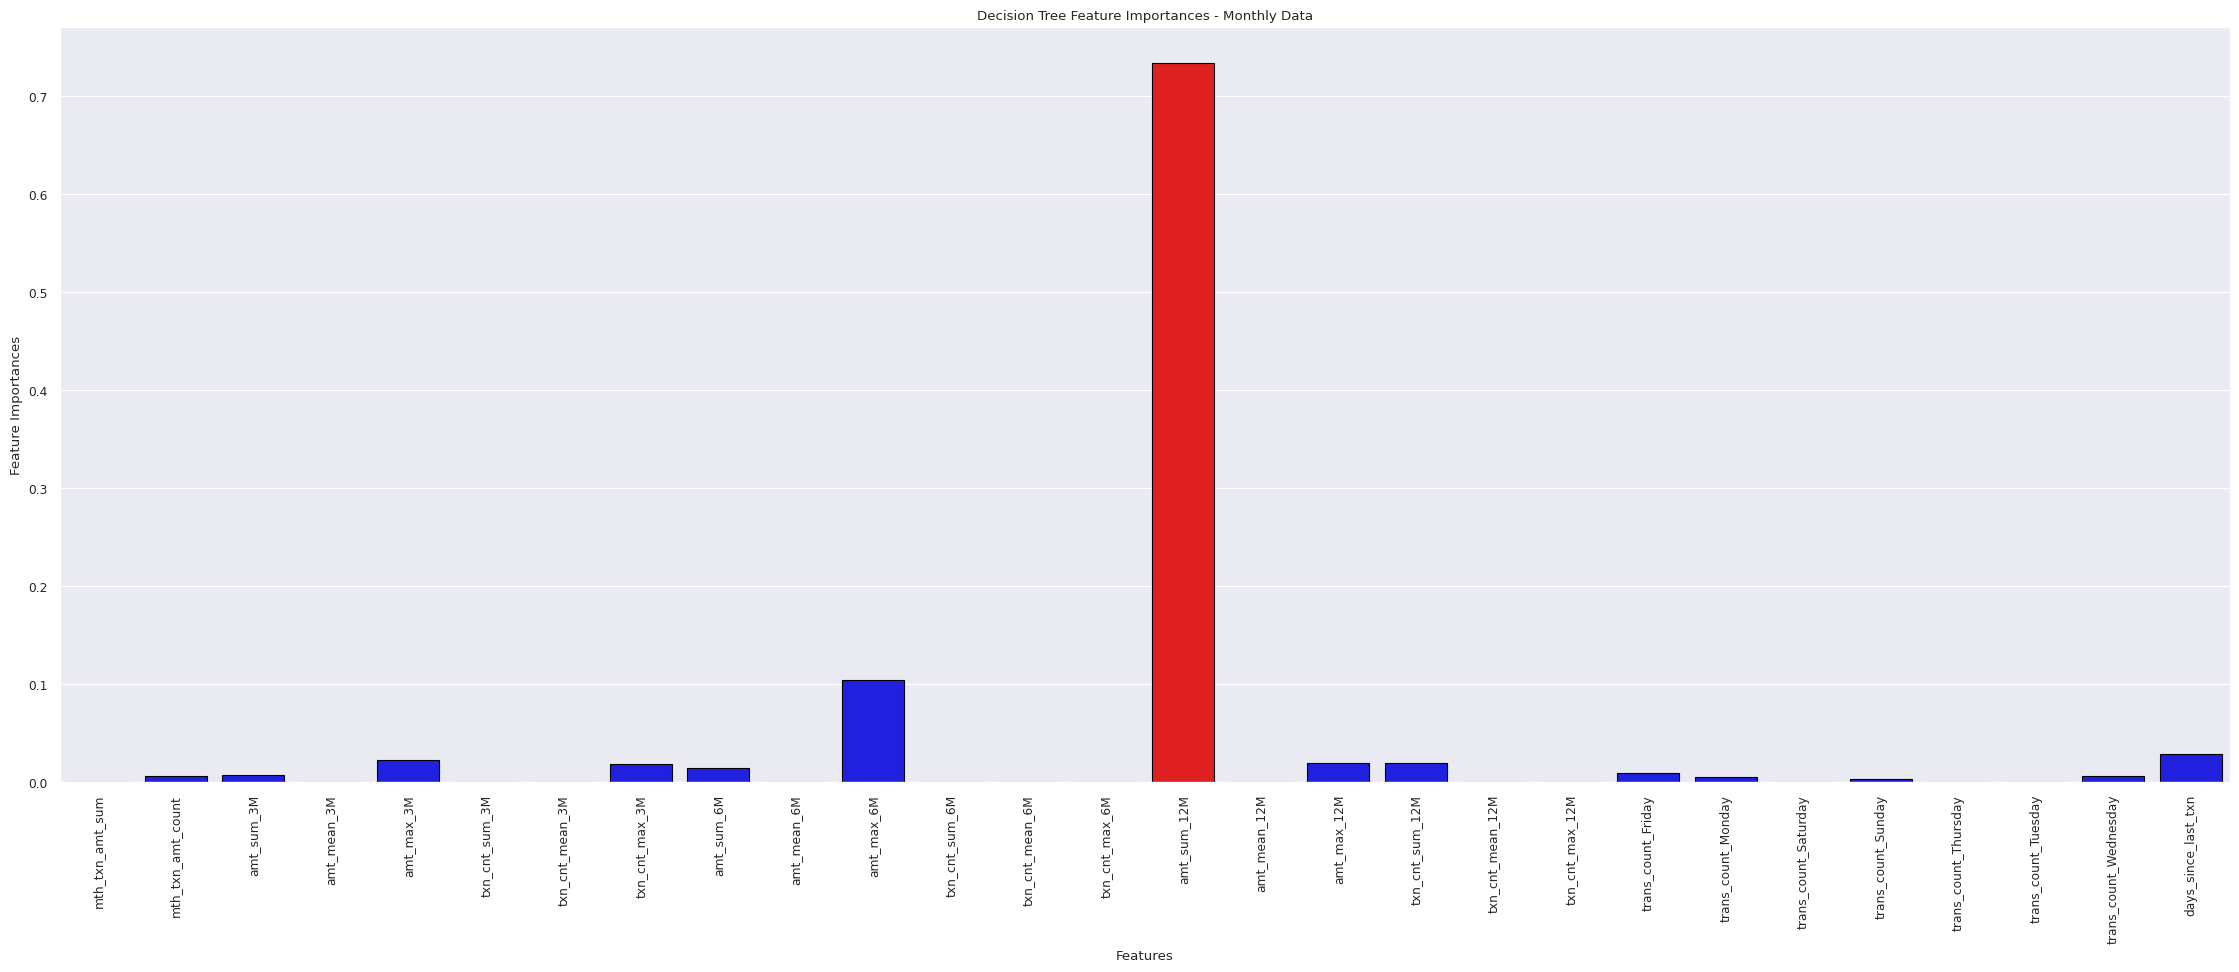

In [0]:
# Extraccting the Model coefficients and converting to Numpy()
feature_imp_mth_dt = best_mth_dt_model.featureImportances
feature_imp_mth_dt = feature_imp_mth_dt.toArray()

# Creating a Dataframe for plotting
feature_imp_mth_dt = pd.DataFrame({'Features': monthly_cols, 'Feature Importances': feature_imp_mth_dt})

# Plotting the Feature Coefficients
# Highlighting the highest coefficient features
colors = ['blue' if i != 14 else 'red' for i in range(len(monthly_cols))]

plt.figure(figsize = (28,10), dpi = 100)
sns.barplot(data = feature_imp_mth_dt, x = 'Features', y = 'Feature Importances', ec = 'black', palette = colors)
plt.xticks(rotation = 90)
plt.title('Decision Tree Feature Importances - Monthly Data')
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.show()

##### 6. Plot probability distribution for test set.

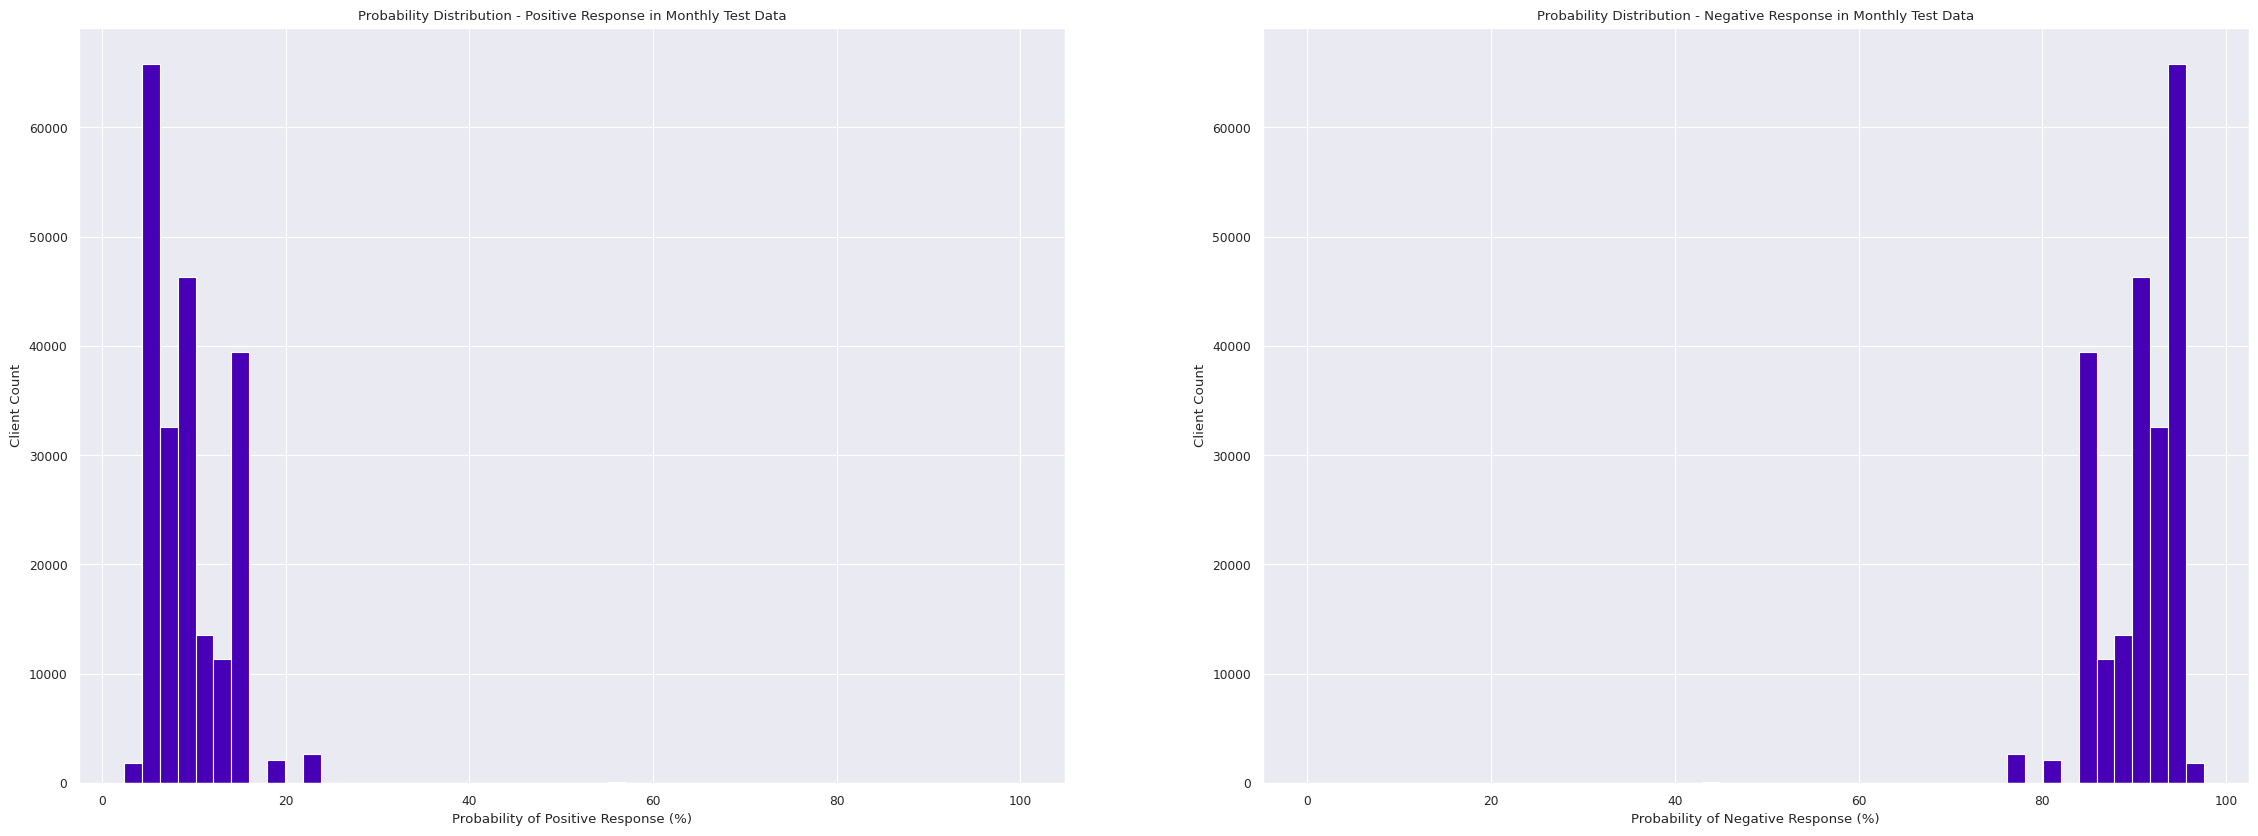

In [0]:
# Probability Distribution for Train set 
probs_train = pred_Train_monthly_dt.select(col('probability')).collect()
probs_train_p = np.array([p[0][1] for p in probs_train]) # Extracting the probability for Positive responses
probs_train_p = probs_train_p * 100 
probs_train_n = np.array([p[0][0] for p in probs_train]) # Extracting the probability for Negative responses
probs_train_n = probs_train_n * 100

# Probability Distribution for Test set 
probs_test = pred_Test_monthly_dt.select(col('probability')).collect()
probs_test_p = np.array([p[0][1] for p in probs_test]) # Extracting the probability for Positive responses
probs_test_p = probs_test_p * 100
probs_test_n = np.array([p[0][0] for p in probs_test]) # Extracting the probability for Negative responses
probs_test_n = probs_test_n * 100

# Plot the probability distribution
fig, ax = plt.subplots(ncols = 2,figsize = (28,10), dpi = 100)
ax[0].hist(probs_test_p, bins = 50, density = False)
ax[0].set_title('Probability Distribution - Positive Response in Monthly Test Data')
ax[0].set_xlabel('Probability of Positive Response (%)')
ax[0].set_ylabel('Client Count')
ax[1].hist(probs_test_n, bins = 50, density = False)
ax[1].set_title('Probability Distribution - Negative Response in Monthly Test Data')
ax[1].set_xlabel('Probability of Negative Response (%)')
ax[1].set_ylabel('Client Count')
plt.show()

##### 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

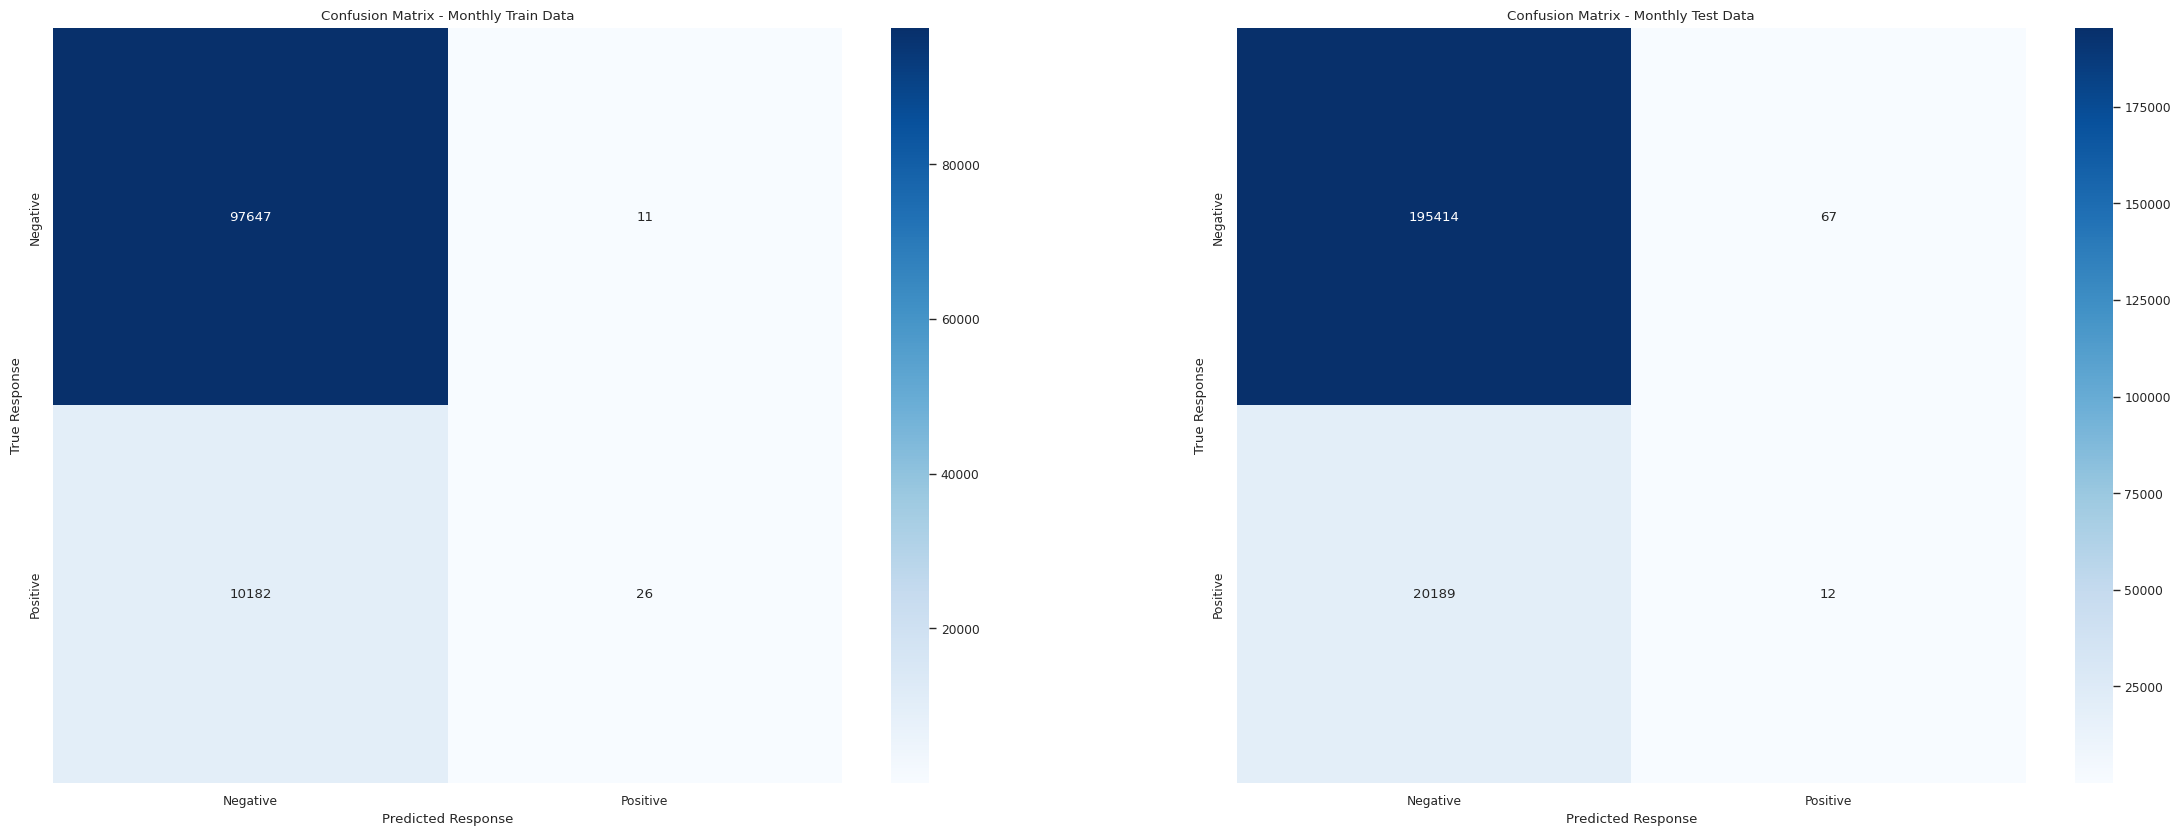

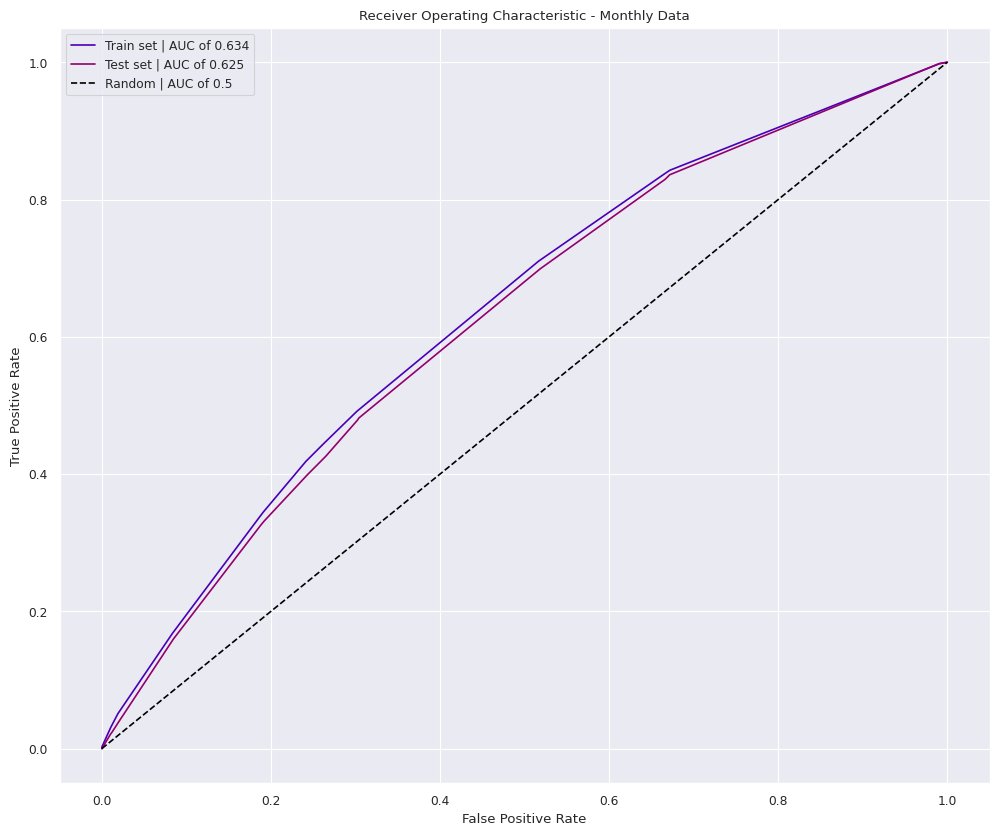

Monthly Train Data Precision = 0.886
Monthly Train Data Recall = 0.906
Monthly Test Data Precision = 0.836
Monthly Test Data Recall = 0.836


In [0]:
# Confusion Matrix Plot
y_true_train = pred_Train_monthly_dt.select('response').collect()
y_pred_train = pred_Train_monthly_dt.select('prediction').collect()
y_true_test = pred_Test_monthly_dt.select('response').collect()
y_pred_test = pred_Test_monthly_dt.select('prediction').collect()

fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (28,10), dpi = 100)
#                     Train Set
sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot = True, fmt = 'g', cmap = 'Blues', ax = ax[0])
ax[0].set_title('Confusion Matrix - Monthly Train Data') 
ax[0].set_xlabel('Predicted Response')
ax[0].set_ylabel('True Response')
ax[0].xaxis.set_ticklabels(['Negative','Positive'])
ax[0].yaxis.set_ticklabels(['Negative','Positive'])

#                     Test Set
sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot = True, fmt = 'g', cmap = 'Blues', ax = ax[1])
ax[1].set_title('Confusion Matrix - Monthly Test Data') 
ax[1].set_xlabel('Predicted Response')
ax[1].set_ylabel('True Response')
ax[1].xaxis.set_ticklabels(['Negative','Positive'])
ax[1].yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

# ROC Curve
#                     Train Set
pred_train = pred_Train_monthly_dt.select(vector_to_array('probability')[1]).rdd.keys().collect()
true_train = pred_Train_monthly_dt.select('response').rdd.keys().collect()
fpr_train, tpr_train, thresholds = roc_curve(true_train, pred_train)
auc_train_dt  = auc(fpr_train, tpr_train)

#                     Test Set
pred_test = pred_Test_monthly_dt.select(vector_to_array('probability')[1]).rdd.keys().collect()
true_test = pred_Test_monthly_dt.select('response').rdd.keys().collect()
fpr_test, tpr_test, thresholds = roc_curve(true_test, pred_test)
auc_test_dt  = auc(fpr_test, tpr_test)

#        ROC Plot with Train and Test Sets
plt.figure(figsize = (12,10), dpi = 100)
plt.title('Receiver Operating Characteristic - Monthly Data')
plt.plot(fpr_train, tpr_train, label = 'Train set | AUC of {:4.3f}'.format(auc_train_dt));
plt.plot(fpr_test, tpr_test, label = 'Test set | AUC of {:4.3f}'.format(auc_test_dt));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

# Calculate Precision and Recall 
#                     Train Set
precision_train = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedPrecision').evaluate(pred_Train_monthly_dt)
recall_train = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedRecall').evaluate(pred_Train_monthly_dt)
print('Monthly Train Data Precision = {:.3f}'.format(precision_train))
print('Monthly Train Data Recall = {:.3f}'.format(recall_train))
# print(classification_report(y_true, y_pred))

#                     Test Set
precision_test = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedPrecision').evaluate(pred_Test_monthly_dt)
recall_test = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedRecall').evaluate(pred_Test_monthly_dt)
print('Monthly Test Data Precision = {:.3f}'.format(precision_test))
print('Monthly Test Data Recall = {:.3f}'.format(precision_test))
# print(classification_report(y_true, y_pred))

#### Random Forest

##### 4. Fit the training dataset and optimize the hyperparameters of the method.

In [0]:
# Random Forest model
rf = RandomForestClassifier(featuresCol = 'scaled_features', labelCol = 'response')

# Pipeline to chain the scaler and the model
# pipeline_rf = Pipeline(stages=[monthly_Assembler, rf])

# Hyperparameter Tuning
# print(rf.explainParams())
Rf_Evaluator = MulticlassClassificationEvaluator(labelCol = 'response')
Num_Trees = [20, 40, 60]
Max_Depth = [2, 4, 6] 
# Subset_Strategy = ['all', 'sqrt', 'log2'] # | Overfitting and Selecting 'all' while it is actually meant to select sqrt since num > 1
Min_Instanes_per_node = [10, 50, 100]

# Parameter grid to search for optimal hyperparameters
param_grid_rf = ParamGridBuilder() \
                .addGrid(rf.numTrees, Num_Trees) \
                .build()
#                 .addGrid(rf.featureSubsetStrategy, Subset_Strategy) \
#                 .addGrid(rf.maxDepth, Max_Depth) \
#                 .addGrid(rf.minInstancesPerNode, Min_Instanes_per_node) \ |Here to avoid error|

# 5-Cross-Validator to perform Cross-Validation
rf_cv = CrossValidator(estimator = rf, estimatorParamMaps = param_grid_rf, evaluator = Rf_Evaluator, numFolds = 5, seed = 1147)

# Fit the scaled train data to the cross-validator to obtain the best model
mth_rf_model = rf_cv.fit(scaled_Train_monthly)

# Transform the train and test set
pred_Train_monthly_rf = mth_rf_model.transform(scaled_Train_monthly)
pred_Test_monthly_rf = mth_rf_model.transform(scaled_Test_monthly)

# Obtain the optimal hyperparameters of the best model
best_mth_rf_model = mth_rf_model.bestModel
best_num_tress = best_mth_rf_model._java_obj.getNumTrees()
best_max_depth = best_mth_rf_model.getMaxDepth()
best_subset_strategy = best_mth_rf_model.getFeatureSubsetStrategy()
best_min_inst = best_mth_rf_model.getMinInstancesPerNode()

# print('The best Impurity is: ', best_imputrity)
print('The best Num Tree is: ', best_num_tress)
print('The best Max Depth is: ', best_max_depth)
print('The best Feature Subset Strategy is: ', best_subset_strategy)
print('The best Min Instances / Node is: ', best_min_inst)

The best Num Tree is:  20
The best Max Depth is:  5
The best Feature Subset Strategy is:  auto
The best Min Instances / Node is:  1


##### 5. Plot coefficient values or feature importance.

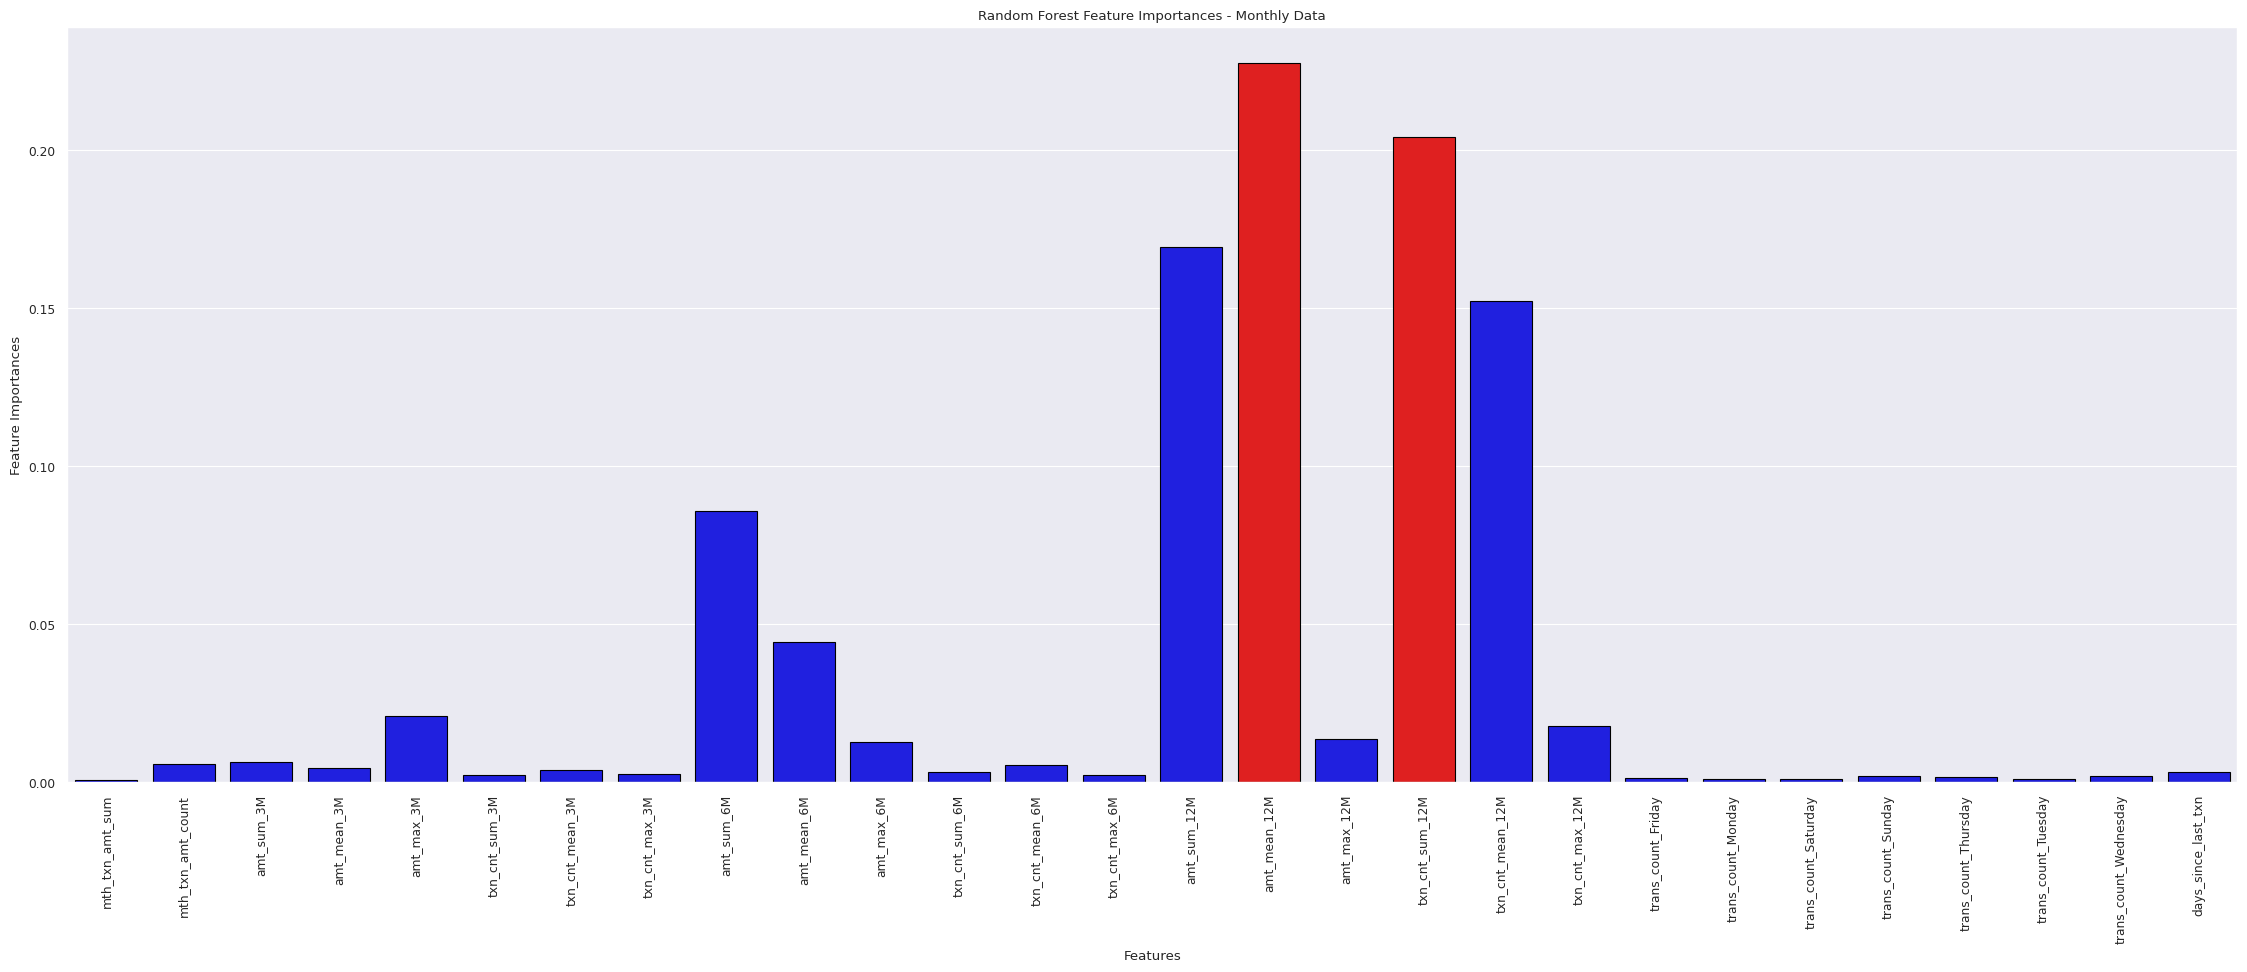

In [0]:
# Extraccting the Model coefficients and converting to Numpy()
feature_imp_mth_rf = best_mth_rf_model.featureImportances
feature_imp_mth_rf = feature_imp_mth_rf.toArray()

# Creating a Dataframe for plotting
feature_imp_mth_rf = pd.DataFrame({'Features': monthly_cols, 'Feature Importances': feature_imp_mth_rf})

# Plotting the Feature Coefficients
# Highlighting the highest coefficient features
colors = ['blue' if i != 15 and i != 17 else 'red' for i in range(len(monthly_cols))]

plt.figure(figsize = (28,10), dpi = 100)
sns.barplot(data = feature_imp_mth_rf, x = 'Features', y = 'Feature Importances', ec = 'black', palette = colors)
plt.xticks(rotation = 90)
plt.title('Random Forest Feature Importances - Monthly Data')
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.show()

##### 6. Plot probability distribution for test set.

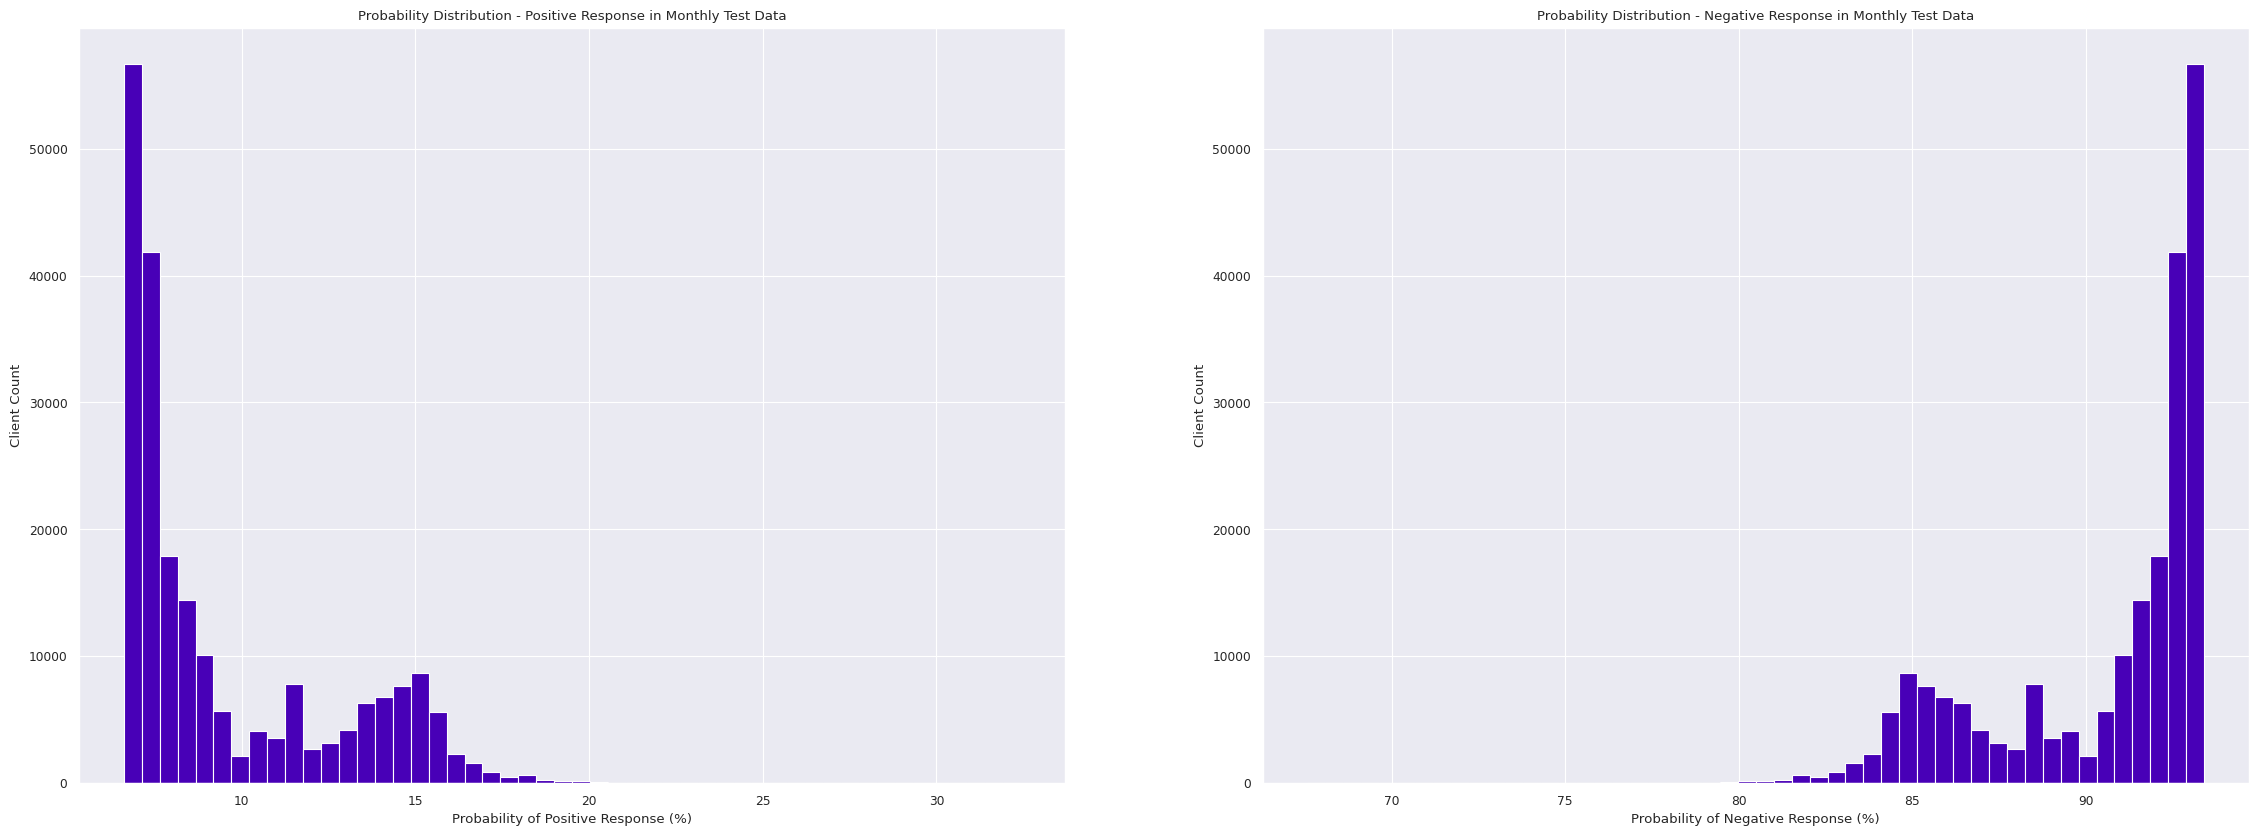

In [0]:
# Probability Distribution for Train set 
probs_train = pred_Train_monthly_rf.select(col('probability')).collect()
probs_train_p = np.array([p[0][1] for p in probs_train]) # Extracting the probability for Positive responses
probs_train_p = probs_train_p * 100 
probs_train_n = np.array([p[0][0] for p in probs_train]) # Extracting the probability for Negative responses
probs_train_n = probs_train_n * 100

# Probability Distribution for Test set 
probs_test = pred_Test_monthly_rf.select(col('probability')).collect()
probs_test_p = np.array([p[0][1] for p in probs_test]) # Extracting the probability for Positive responses
probs_test_p = probs_test_p * 100
probs_test_n = np.array([p[0][0] for p in probs_test]) # Extracting the probability for Negative responses
probs_test_n = probs_test_n * 100

# Plot the probability distribution
fig, ax = plt.subplots(ncols = 2,figsize = (28,10), dpi = 100)
ax[0].hist(probs_test_p, bins = 50, density = False)
ax[0].set_title('Probability Distribution - Positive Response in Monthly Test Data')
ax[0].set_xlabel('Probability of Positive Response (%)')
ax[0].set_ylabel('Client Count')
ax[1].hist(probs_test_n, bins = 50, density = False)
ax[1].set_title('Probability Distribution - Negative Response in Monthly Test Data')
ax[1].set_xlabel('Probability of Negative Response (%)')
ax[1].set_ylabel('Client Count')
plt.show()

##### 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

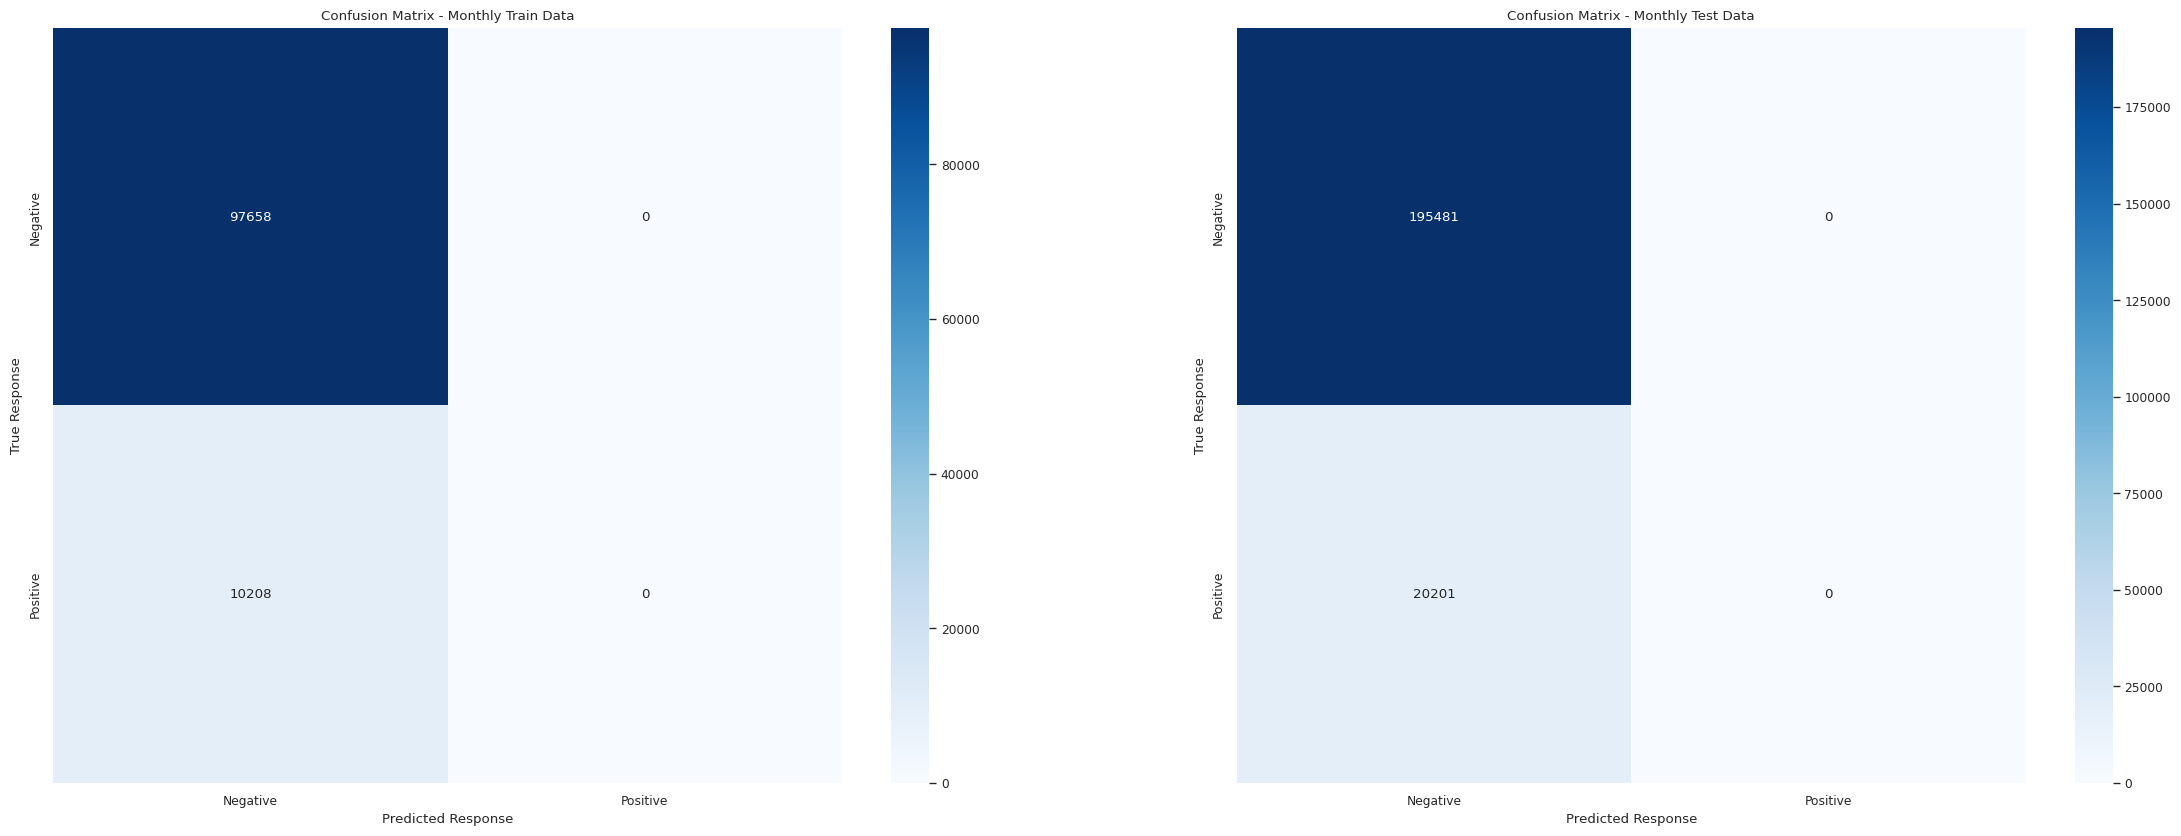

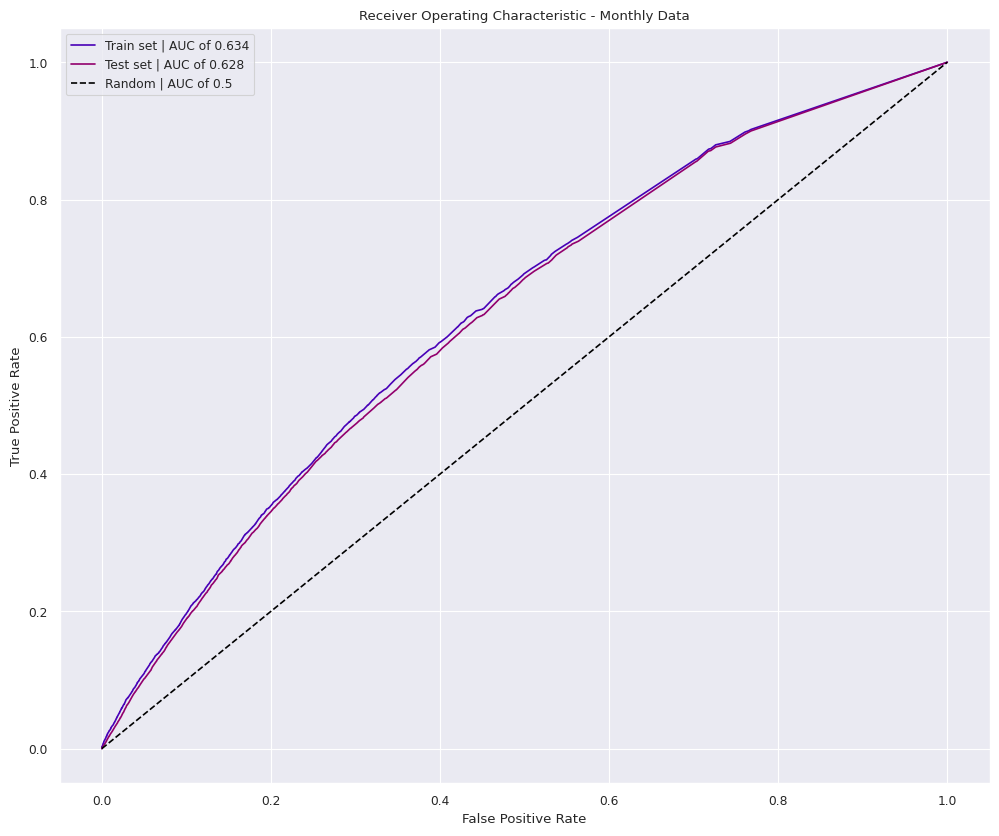

Monthly Train Data Precision = 0.820
Monthly Train Data Recall = 0.905
Monthly Test Data Precision = 0.821
Monthly Test Data Recall = 0.821


In [0]:
# Confusion Matrix Plot
y_true_train = pred_Train_monthly_rf.select('response').collect()
y_pred_train = pred_Train_monthly_rf.select('prediction').collect()
y_true_test = pred_Test_monthly_rf.select('response').collect()
y_pred_test = pred_Test_monthly_rf.select('prediction').collect()

fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (28,10), dpi = 100)
#                     Train Set
sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot = True, fmt = 'g', cmap = 'Blues', ax = ax[0])
ax[0].set_title('Confusion Matrix - Monthly Train Data') 
ax[0].set_xlabel('Predicted Response')
ax[0].set_ylabel('True Response')
ax[0].xaxis.set_ticklabels(['Negative','Positive'])
ax[0].yaxis.set_ticklabels(['Negative','Positive'])

#                     Test Set
sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot = True, fmt = 'g', cmap = 'Blues', ax = ax[1])
ax[1].set_title('Confusion Matrix - Monthly Test Data') 
ax[1].set_xlabel('Predicted Response')
ax[1].set_ylabel('True Response')
ax[1].xaxis.set_ticklabels(['Negative','Positive'])
ax[1].yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

# ROC Curve
#                     Train Set
pred_train = pred_Train_monthly_rf.select(vector_to_array('probability')[1]).rdd.keys().collect()
true_train = pred_Train_monthly_rf.select('response').rdd.keys().collect()
fpr_train, tpr_train, thresholds = roc_curve(true_train, pred_train)
auc_train_dt  = auc(fpr_train, tpr_train)

#                     Test Set
pred_test = pred_Test_monthly_rf.select(vector_to_array('probability')[1]).rdd.keys().collect()
true_test = pred_Test_monthly_rf.select('response').rdd.keys().collect()
fpr_test, tpr_test, thresholds = roc_curve(true_test, pred_test)
auc_test_dt  = auc(fpr_test, tpr_test)

#        ROC Plot with Train and Test Sets
plt.figure(figsize = (12,10), dpi = 100)
plt.title('Receiver Operating Characteristic - Monthly Data')
plt.plot(fpr_train, tpr_train, label = 'Train set | AUC of {:4.3f}'.format(auc_train_dt));
plt.plot(fpr_test, tpr_test, label = 'Test set | AUC of {:4.3f}'.format(auc_test_dt));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

# Calculate Precision and Recall 
#                     Train Set
precision_train = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedPrecision').evaluate(pred_Train_monthly_rf)
recall_train = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedRecall').evaluate(pred_Train_monthly_rf)
print('Monthly Train Data Precision = {:.3f}'.format(precision_train))
print('Monthly Train Data Recall = {:.3f}'.format(recall_train))
# print(classification_report(y_true, y_pred))

#                     Test Set
precision_test = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedPrecision').evaluate(pred_Test_monthly_rf)
recall_test = MulticlassClassificationEvaluator(labelCol = 'response', predictionCol = 'prediction', metricName = 'weightedRecall').evaluate(pred_Test_monthly_rf)
print('Monthly Test Data Precision = {:.3f}'.format(precision_test))
print('Monthly Test Data Recall = {:.3f}'.format(precision_test))
# print(classification_report(y_true, y_pred))

## 1.3 Comparison of methods (5 points)

Compare the two feature engineering (annual and monthly) and the three modeling approaches (L1 log-reg, tree, forests) in terms of the outcomes of steps 5-7. Which combination of feature engineering and modeling approach do you select as the best to deploy in a production environment and why? Tabularize your findings in steps 5-7 to summarize the results and support your decision (how to organize information with tables in Markdown).

**Train Set AUC Values & Test Set AUC Values** 

| Model | Annual Model Train AUC  | Monthly Model Train AUC | Annual Model Test AUC  | Monthly Model Test AUC | 
| ------------- | ------------- | ------------- | ------------- | ------------- |
| LogReg | 79.4  | 62.2  | 77.3  | 61.8  |
| Decision Tree | 75.5  | 63.4  | 72.5  | 62.5  |
| Random Forest | 90.9  | 63.4  | 75.3  | 62.8  |

**Train AUC - Test AUC**

| Model | Annual Model AUC Differences | Monthly Model AUC Differences | 
| ------------- | ------------- | ------------- |
| LogReg | 2.1 | 0.4  |
| Decision Tree | 3.0 | 0.9 |
| Random Forest | 15.6 | 0.5 |

**Train Set Precision Values & Test Set Precision Values** 

| Model | Annual Model Train Precision  | Monthly Model Train Precision | Annual Model Test Precision  | Monthly Model Test Precision | 
| ------------- | ------------- | ------------- | ------------- | ------------- |
| LogReg | 84.9 | 82.0 | 84.1 | 82.1 |
| Decision Tree | 89.9 | 88.6 | 84.1 | 83.6 |
| Random Forest | 92.0 | 82.0 | 84.3 | 82.1 |

**Train Set Recall Values & Test Set Recall Values** 

| Model | Annual Model Train Recall  | Monthly Model Train Recall | Annual Model Test Recall  | Monthly Model Test Recall | 
| ------------- | ------------- | ------------- | ------------- | ------------- |
| LogReg | 90.8 | 90.5 | 84.1 | 82.1 |
| Decision Tree | 91.3 | 90.6 | 84.1 | 83.6 |
| Random Forest | 91.2 | 90.5 | 84.3  | 82.1 |

**Annual Analysis**

Based on the above tables, it can be seen that the the **Random Forest** is the best model to deploy in the industry based solely on the Precision and Recall of the models.

However, comparing the individual train models, and looking at the Test AUC values, it can be seen that LogReg and Random Forest have similar values with a difference of only 5% while the Random Forest has a stunning 15.6%. At one look, one may say that the best model is Random Forest but they may have not considered the high variance in the model or the risk of Overfitting. 

Furthur comparing the Train AUCs with the Test AUCs and calculating the difference between the 2 values, it can be seen that the **LogReg** serves as a **better model** because the difference between the Train and Test AUC is the least. On the contrary, the model that had the best Train AUC, is acutally the worst because it may have overfit during the training of the model. 

**Thus an ideal choice based on the data provided and the possible porcessing, the Best Model for Annual Features would be LogReg (Logistic Regression Model).**

**Monthly Analysis**

Accourding to the tables above, based on Accuracy, one can say that the **Decision Tree** is the best model, however he may have not checked the details of the Train and Test AUC Values.

Having a look at the Train AUC values of the models, Random Forest appears to be the best as it has the highest precision and recall of 91.2% and 84.3% respectively, followed by LogReg and lastly Decision Tree. But this is just train data. Comparing with the Test AUC values, a similar trend can be observed in the rankings with Random Forest first, followed by LogReg and then Decision Tree.

Its the difference between the 2 AUC values for each model that actually reveals the better model in all 3. Looking a the 3rd table, it can be seen that eventhough Random Froest has the best Train and Test Values, it has the highest difference when compared to Simple Tree and LogReg, a value of 4.1%. Which basically means, that eventhough the model is able to train well and have a good accuracy, it is not able to predict well.

Thus, the difference indicates that **Decision Tree** is the **better model** based on the difference between the Train and Test AUC values and supported by the higher accuracy of the model. In Layman's Language, it basically means that Decision Tree trains well and predicts well aswell eventhough it has an accuracy close to 70%.

The other models are not an ideal choice as a model that trains well but doesn't predict well, will ultimatly lead to huge financial disasters thus a very bad choice. 

**Thus an ideal choice based on the data provided and the possible porcessing, the Best Model for Monthly Features would be Decision Tree.**



**Therefore an ideal choice would be just 1 model from 1 data set, which would be the model that has the best Recall value in Test set but also has not overfit, which would be the Annual Data set with the L1 Regularization Logistic Regression Model.**